In [ ]:
# Checking for bug

In [11]:
# importing packages and modules
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize
from utils import *
from plotting_utils import *
from analysis_utils import *
import dglm_hmm2
import dglm_hmm1
from scipy.stats import multivariate_normal, norm
# import jax

sns.set_context("talk")

In [12]:
# setting hyperparameters
S = 10 # sessions
T = 10000 # trials per session
N = T * S # total data points
C = 2 # classes
K = 2 # states
D = 2 # features (sensory & bias)

Session indicies
[0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000]
(100000, 2, 2, 2)


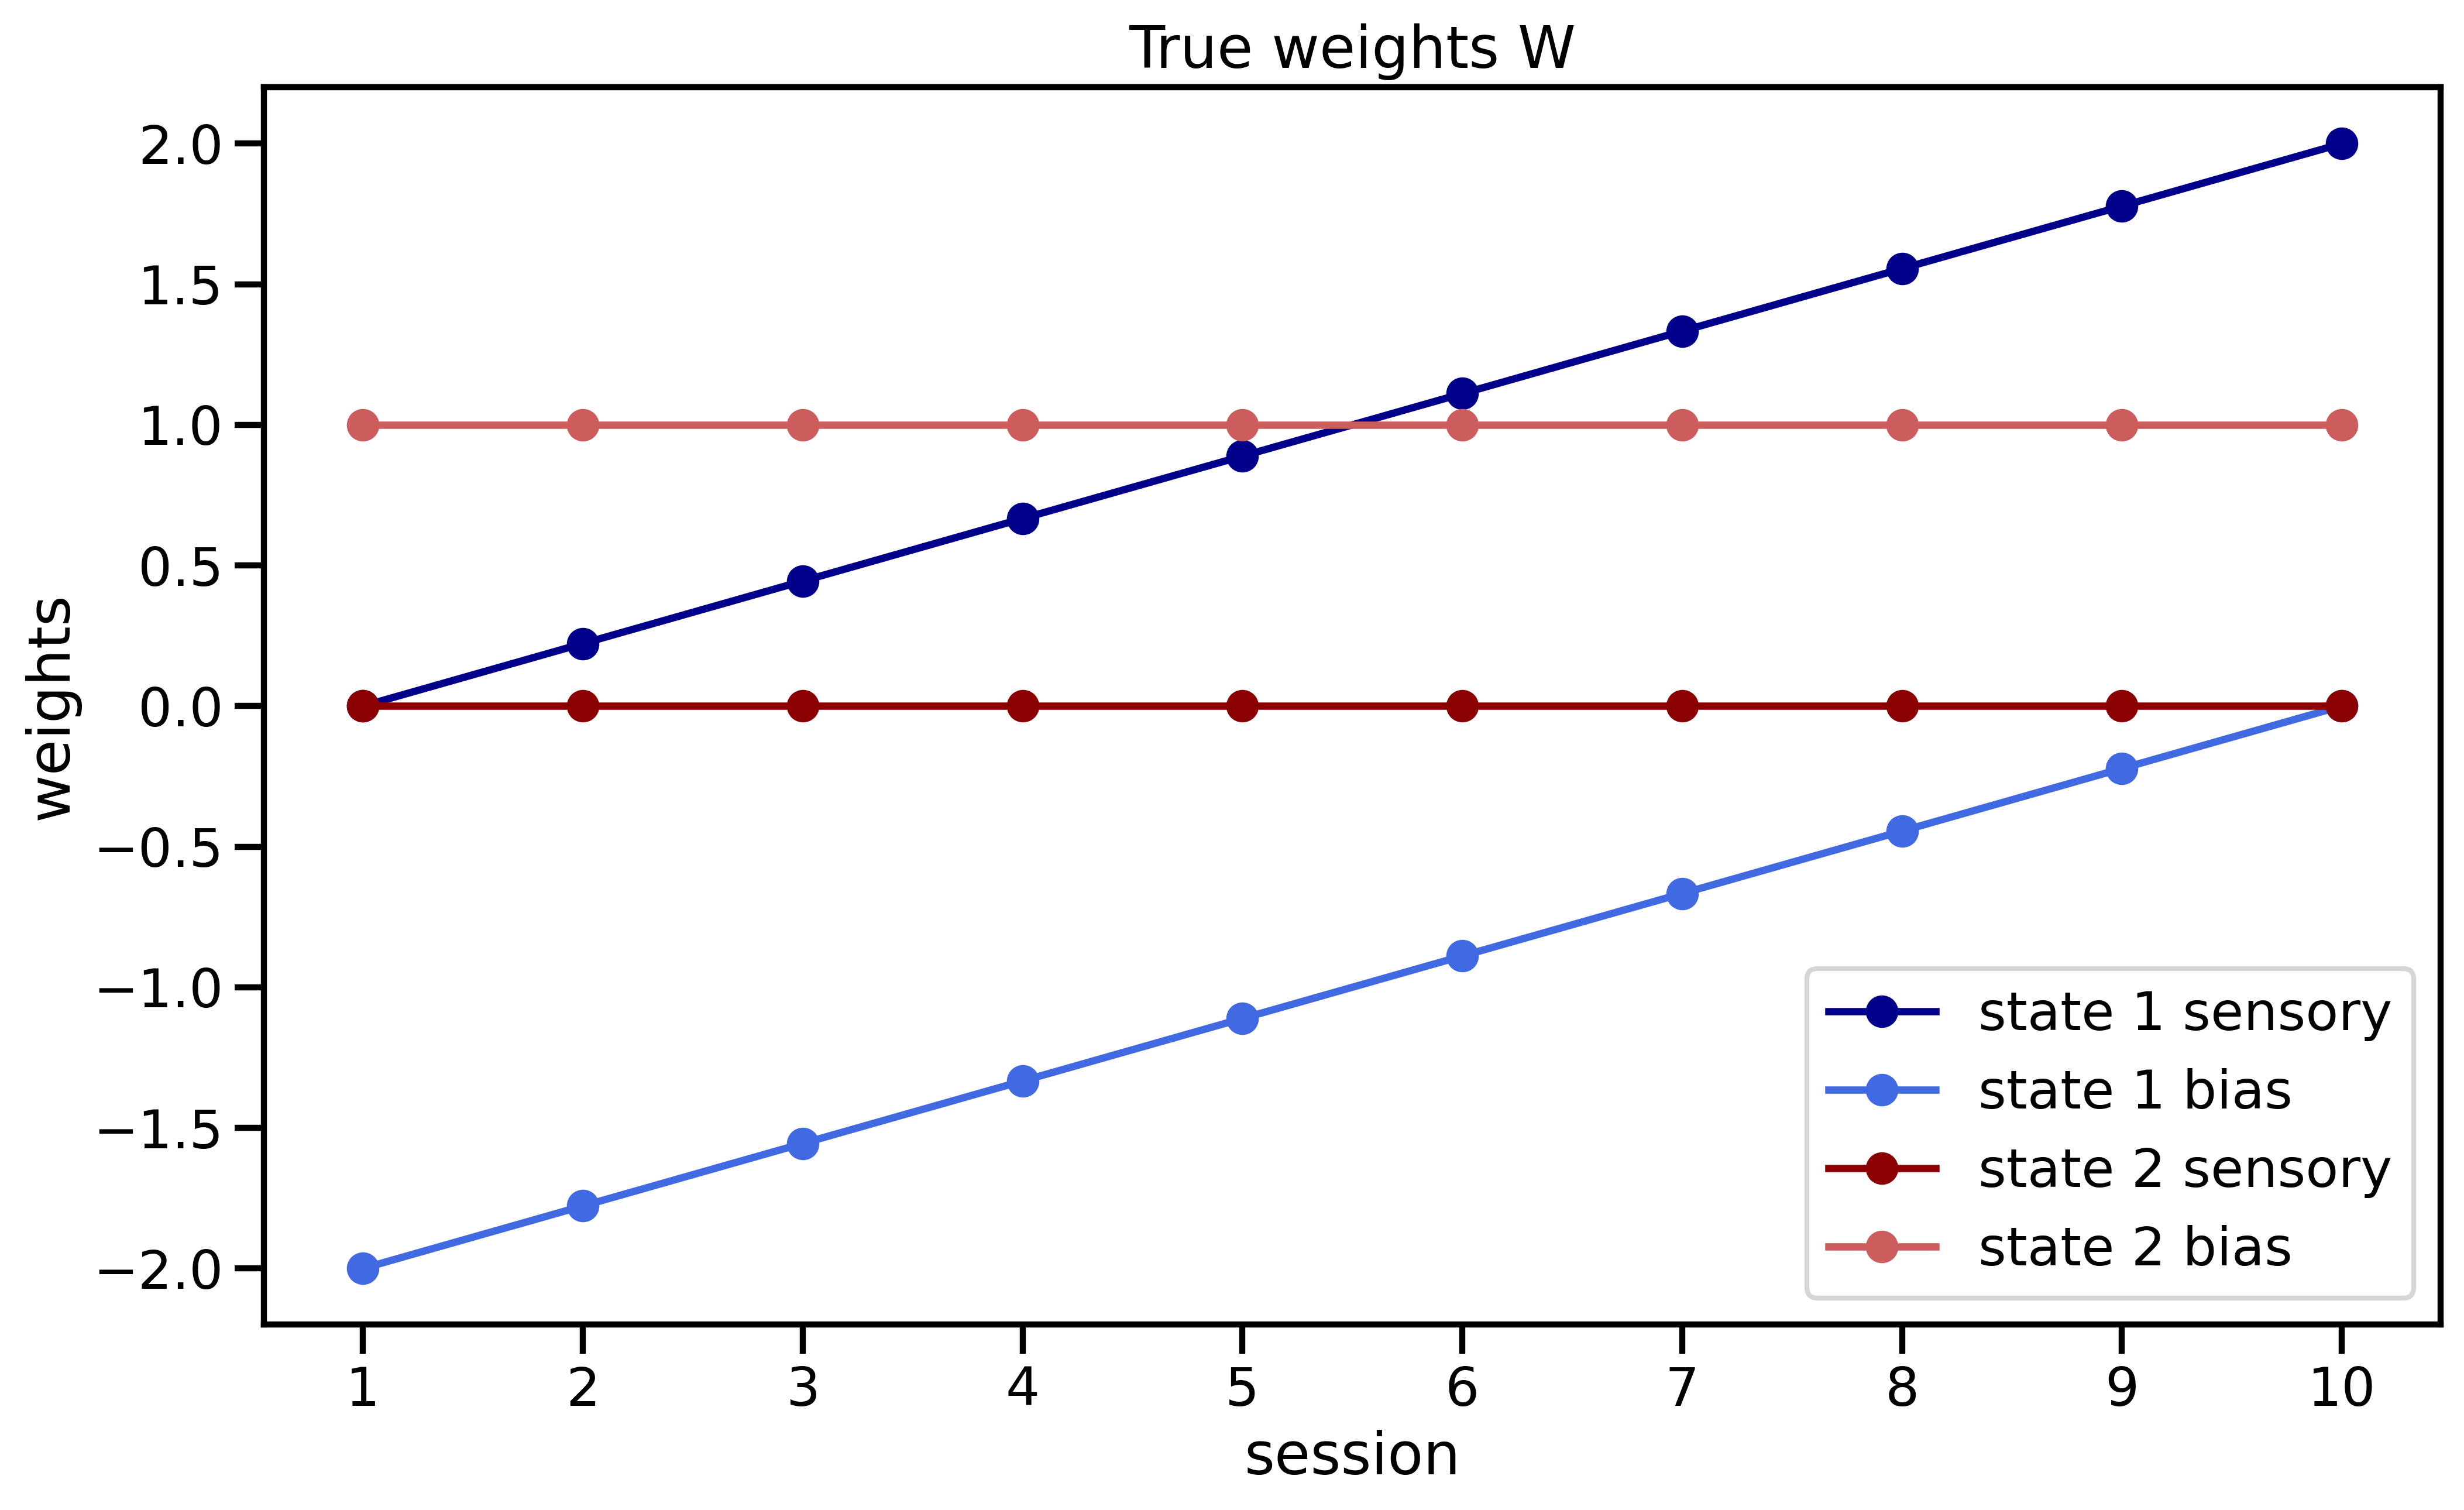

In [22]:
# True Weights and Session Start Indices
ourW = np.zeros((S,K,D))
ourW[:,0,1] = np.linspace(0,2,S) # state 1 sensory (increasing)
ourW[:,0,0] = np.linspace(-2,0,S) # state 1 bias (decreasing)
ourW[:,1,1] = 0 # state 2 sensory (flat 0)
ourW[:,1,0] = 1 # state 2 bias (flat 1)
trueW = np.zeros((N,K,D,C))
# change weight format to have session*trials points
sessInd = []
for sess in range(0,S):
    sessInd.append(sess*T)
    for t in range(0,T):
        trueW[sess*T+t,:,:,1] = ourW[sess,:,:]
sessInd.append(N)
print("Session indicies")
print(sessInd)

testSessInd = []
for sess in range(0,S+1):
    testSessInd.append(sess*10000)

print(trueW.shape)
fig, axes = plt.subplots(1, figsize = (12,7), dpi=400)
plotting_weights(w=trueW, sessInd=sessInd, axes=axes, trueW=None, title='True weights W', save_fig=False)

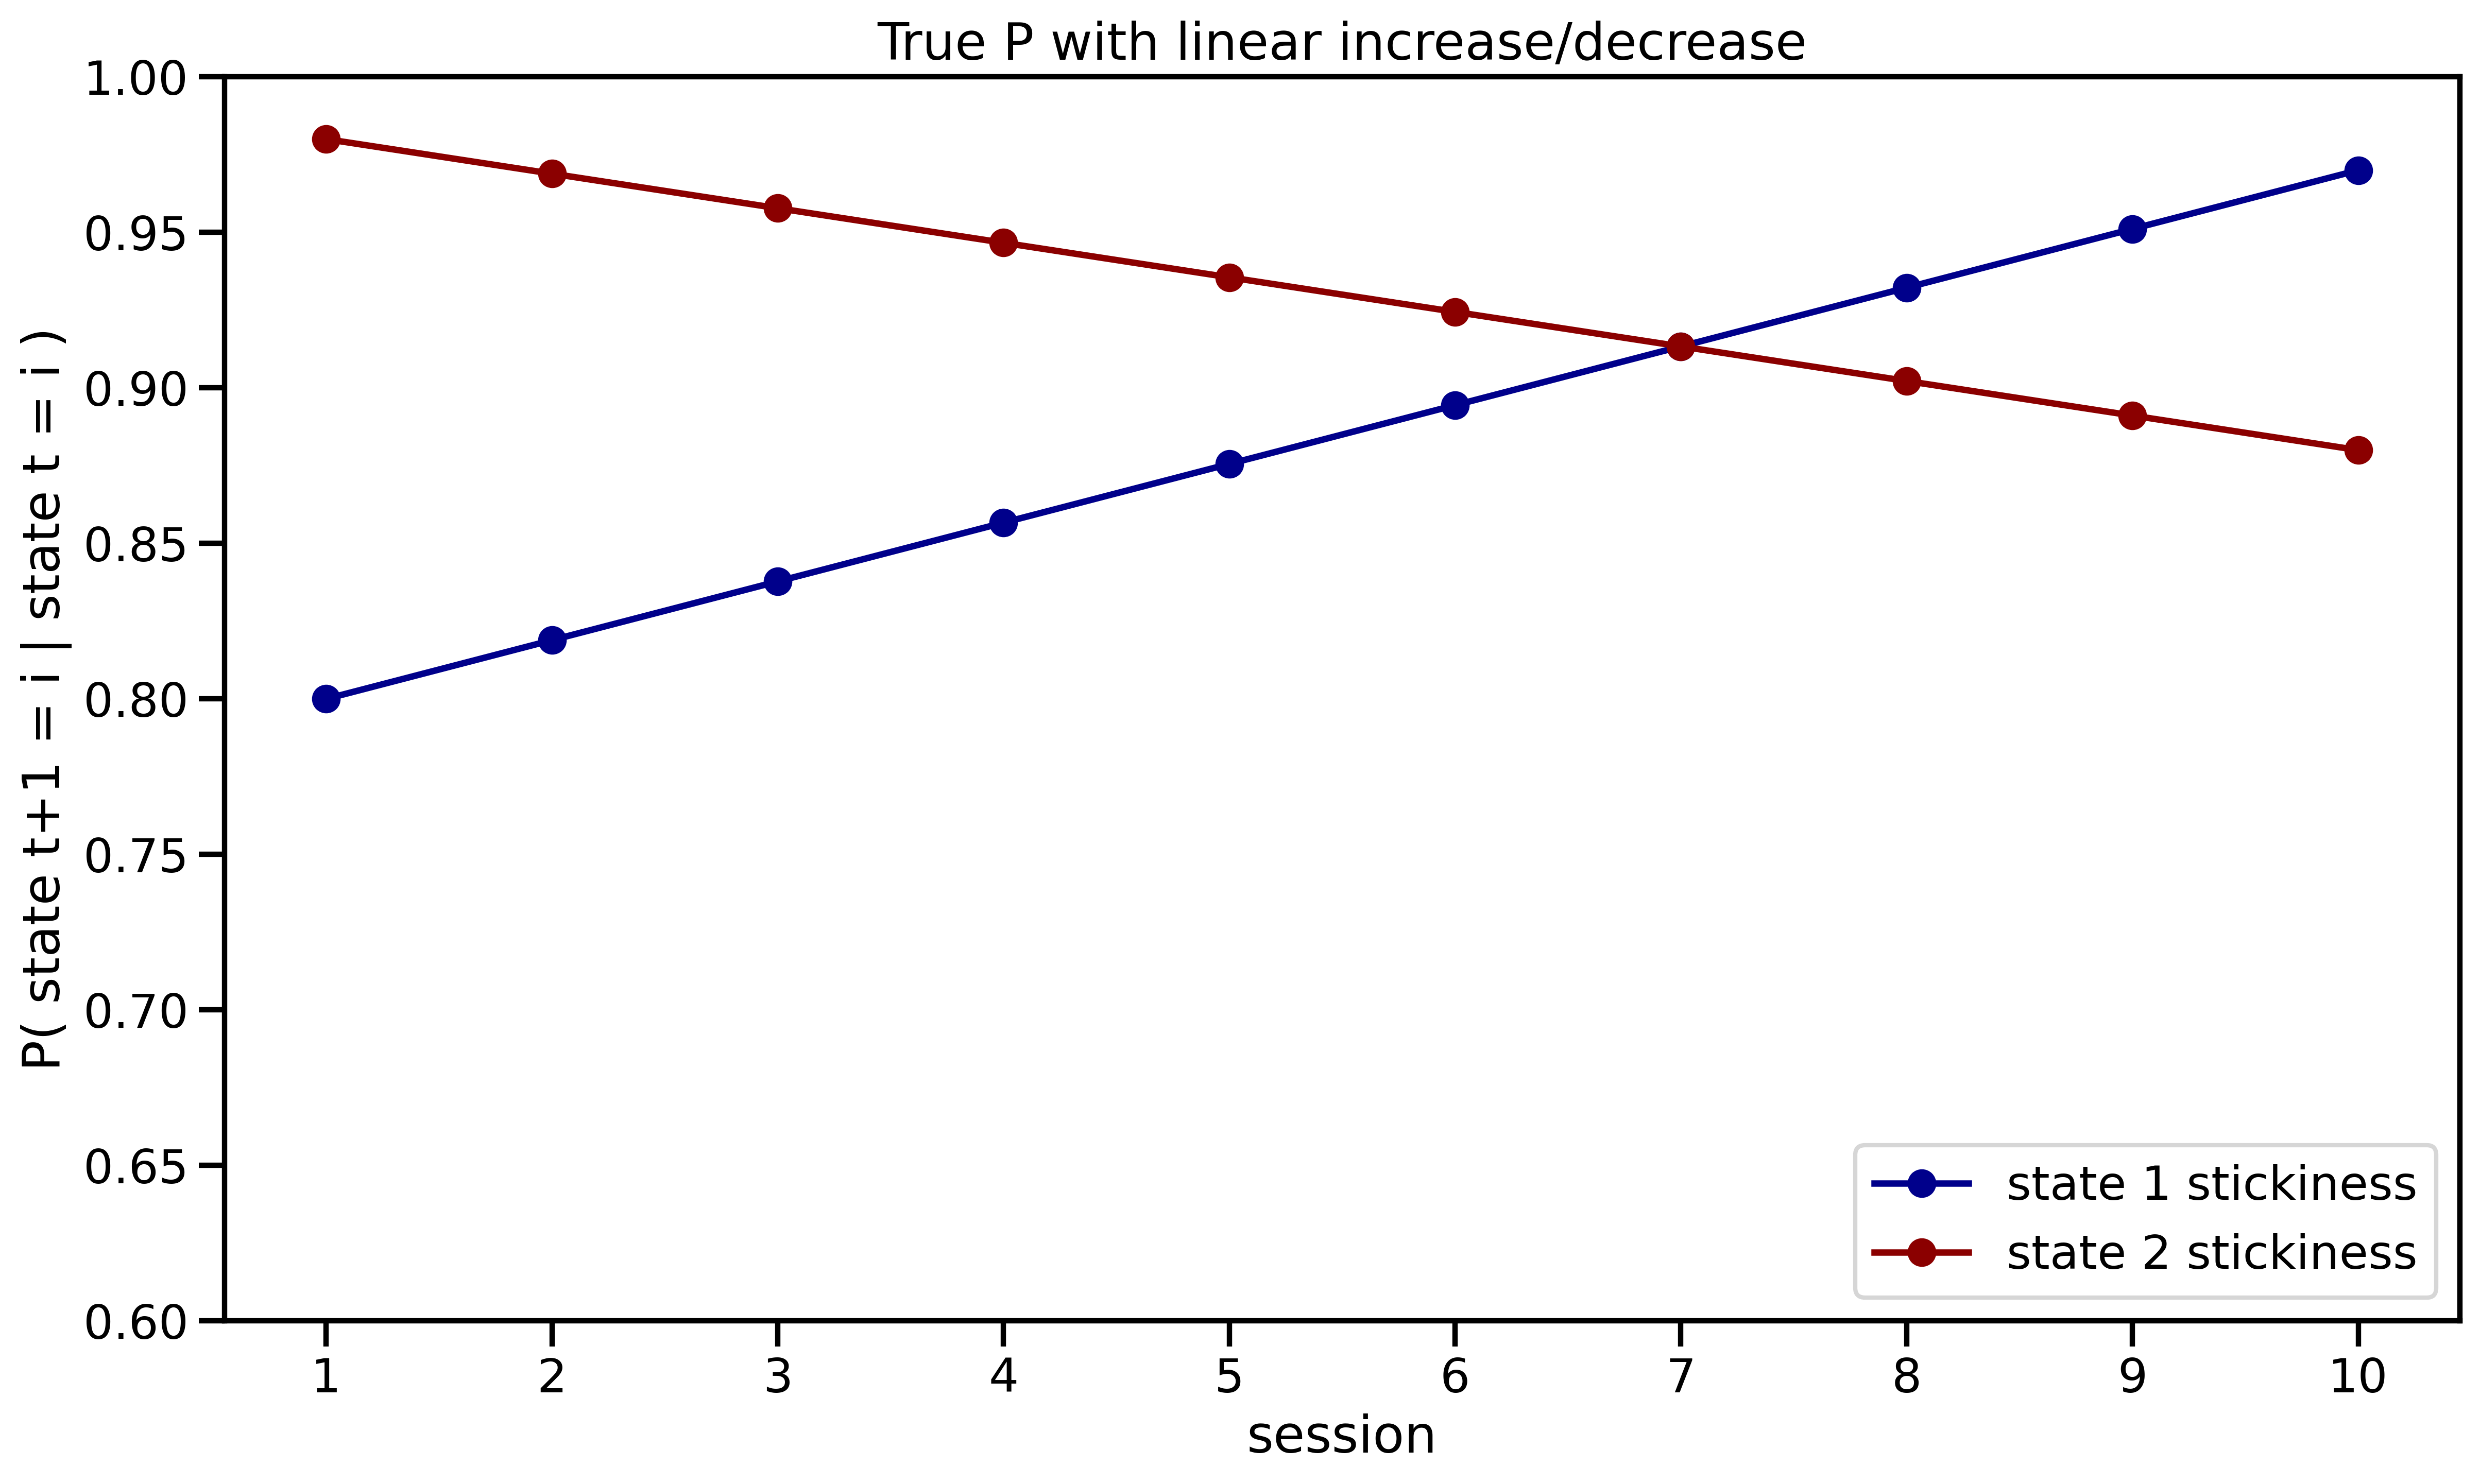

In [14]:
ourP = np.zeros((S,K,K))
ourP[:,0,0] = np.linspace(0.8,0.97,S) # state 1 sensory (increasing)
ourP[:,1,1] = np.linspace(0.98,0.88,S) # state 1 bias (decreasing)
ourP[:,0,1] = 1 - ourP[:,0,0]
ourP[:,1,0] = 1 - ourP[:,1,1]

trueP = np.zeros((N,K,K))
for sess in range(0,S):
    for t in range(0,T):
        trueP[sess*T+t] = ourP[sess]

fig, axes = plt.subplots(1, figsize = (14,8), dpi=400)
plotting_transition_matrix_stickiness(trueP, sessInd, axes, trueP=None, title=f'True P with linear increase/decrease', save_fig=False)

In [23]:
dGLMHMM = dglm_hmm2.dGLM_HMM2(N,K,D,C)
# x, y, z = dGLMHMM.simulate_data(trueW, trueP, sessInd, save=True, title=f'N={N}_{K}_state_linearP_train', pi0=0.5)
# x, y, z = dGLMHMM.simulate_data(trueW, trueP, sessInd, save=True, title=f'N={N}_{K}_state_linearP_test', pi0=0.5)
trainX = np.load(f'../data/N={N}_{K}_state_linearP_trainX.npy')
trainY = np.load(f'../data/N={N}_{K}_state_linearP_trainY.npy')
testX = np.load(f'../data/N={N}_{K}_state_linearP_testX.npy')
testY = np.load(f'../data/N={N}_{K}_state_linearP_testY.npy')


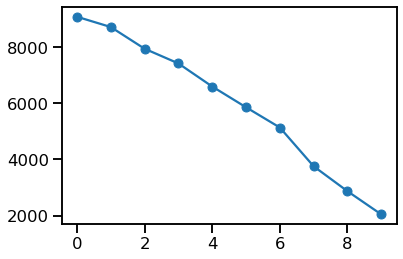

In [24]:
totalZ = np.zeros((len(sessInd)-1))
for s in range(0,len(sessInd)-1):
    totalZ[s] = np.sum(z[sessInd[s]:sessInd[s+1]])

plt.plot(range(0,len(sessInd)-1), totalZ, marker='o')
plt.show()
    

In [17]:
oneSessInd = [0,N] # treating whole dataset as one session for normal GLM-HMM fitting
maxiter=1000
dGLMHMM1 = dglm_hmm1.dGLM_HMM1(N,K,D,C)
initP0, initW0 = dGLMHMM1.generate_param(sessInd=oneSessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['uniform', (-2,2)]) # initial random param
initP,  initW, _ = dGLMHMM1.fit(trainX, trainY,  initP0, initW0, sigma=reshapeSigma(1, K, D), sessInd=oneSessInd, pi0=None, maxIter=300, tol=1e-4) # GLM-HMM param # sigma does not matter
checkP0,  checkW0, _ = dGLMHMM1.fit(trainX, trainY,  initP, initW, sigma=reshapeSigma(0.2, K, D), sessInd=sessInd, pi0=None, maxIter=300, tol=1e-4) # dGLM-HMM1 
checkP, checkW, checkLl = dGLMHMM.fit(trainX, trainY,  initP=reshapeP_M1_to_M2(checkP0, N), initW=checkW0, sigma=reshapeSigma(0.2, K, D), alpha=0, globalP=checkP0, sessInd=sessInd, pi0=None, maxIter=maxiter, tol=1e-3) # fit the model
# checkP, checkW, checkLl = dGLMHMM.fit(trainX, trainY,  initP=reshapeP_M1_to_M2(initP, N), initW=initW, sigma=reshapeSigma(0.2, K, D), sessInd=sessInd, pi0=None, maxIter=600, tol=1e-3) # fit the model


0
10
20
30
40
50
0
10
20
30
40
50
60
70
80
0
10
20
30
40
50


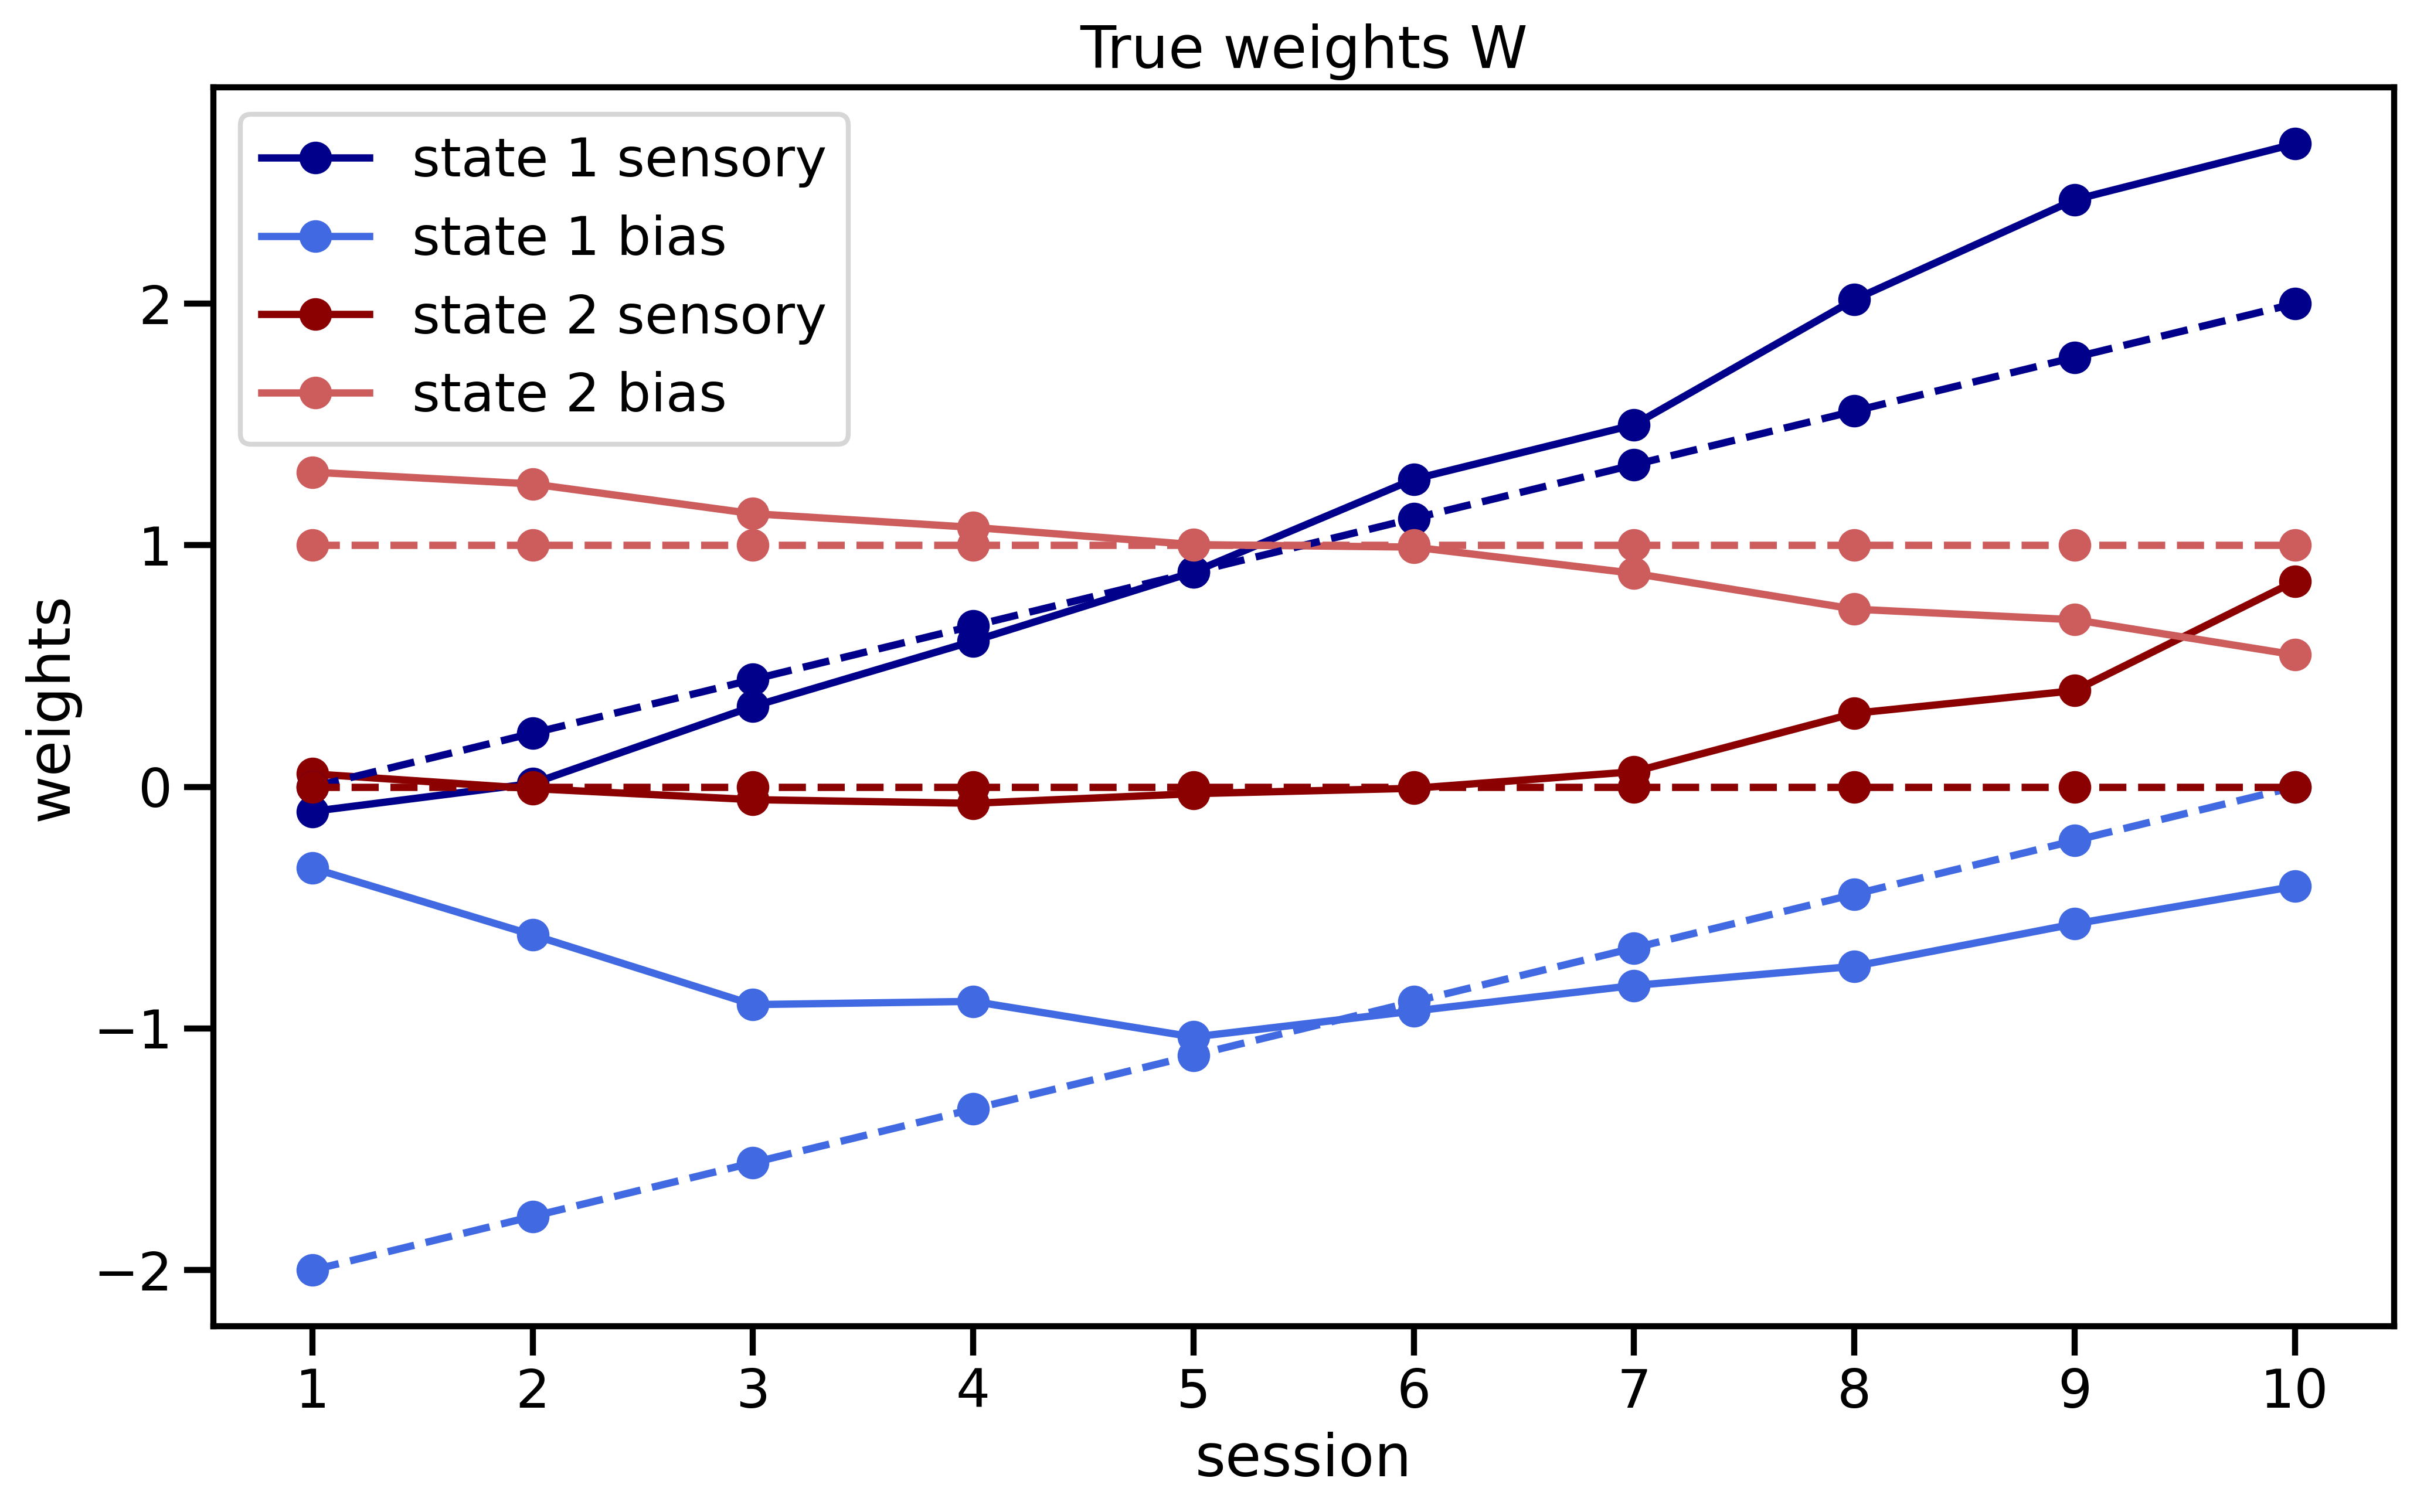

In [20]:
fig, axes = plt.subplots(1, figsize = (12,7), dpi=400)
plotting_weights(w=checkW0, sessInd=sessInd, axes=axes, trueW=trueW, title='True weights W', save_fig=False)

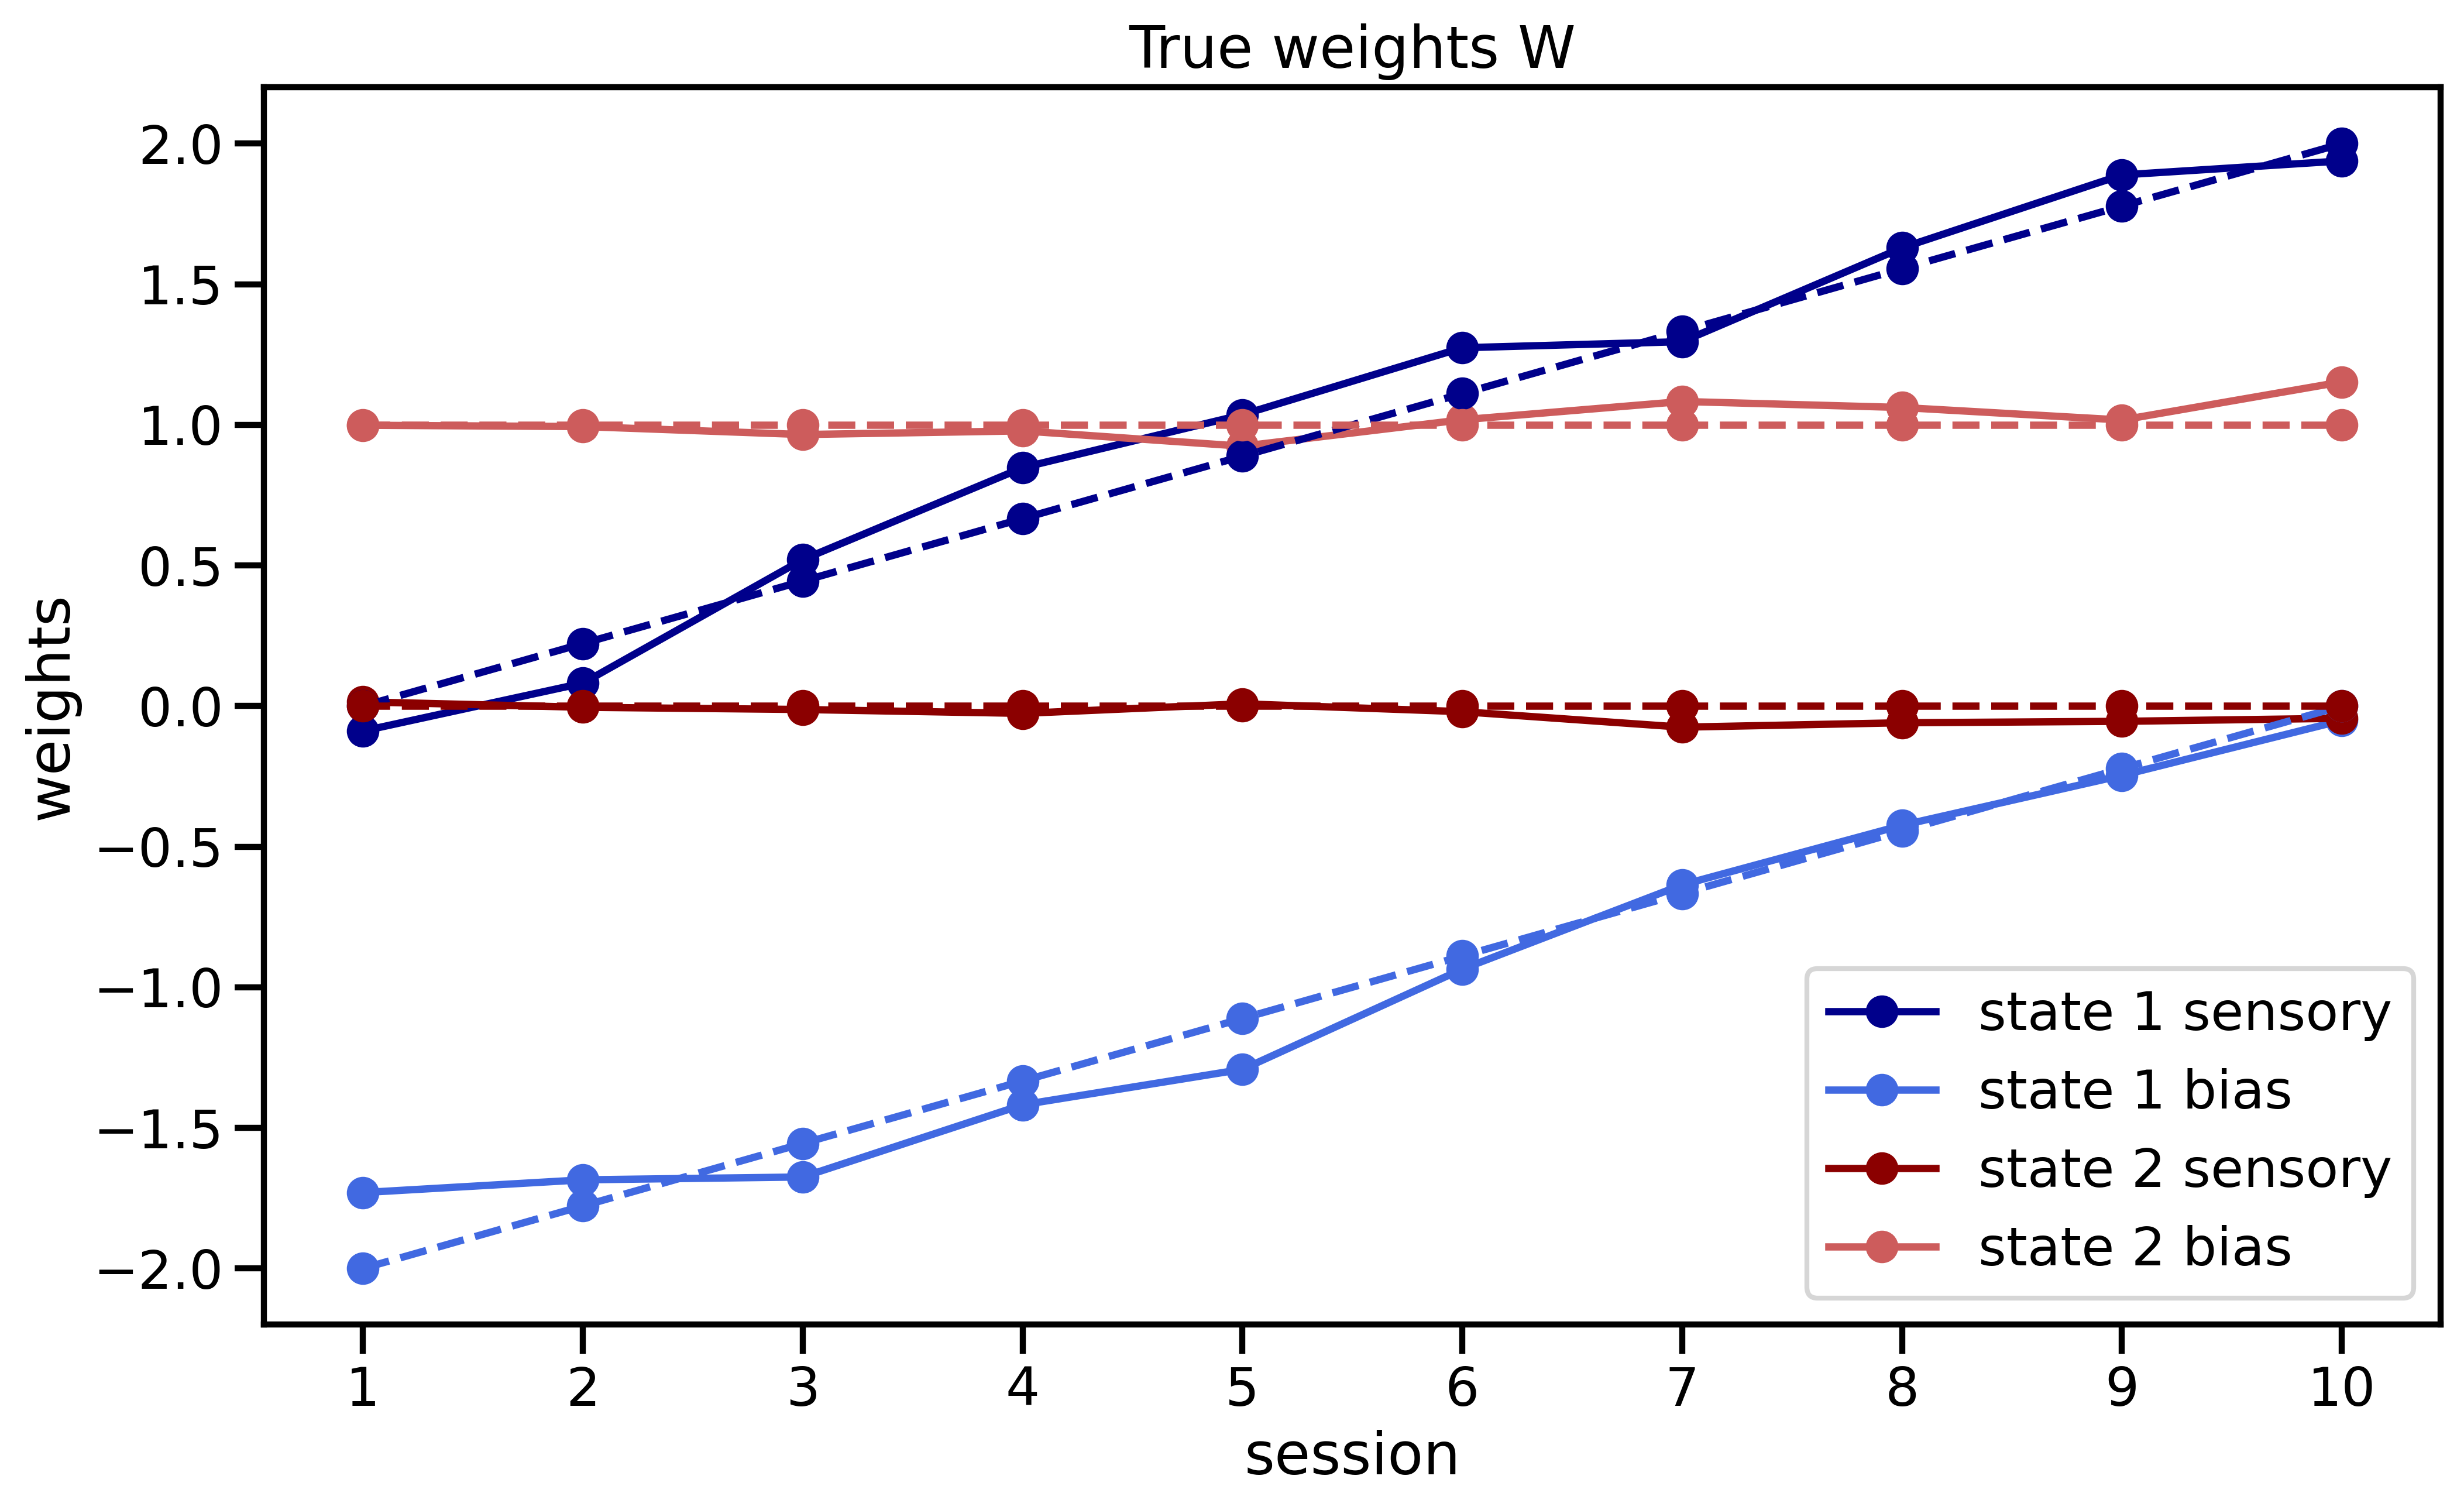

In [18]:
fig, axes = plt.subplots(1, figsize = (12,7), dpi=400)
plotting_weights(w=checkW, sessInd=sessInd, axes=axes, trueW=trueW, title='True weights W', save_fig=False)

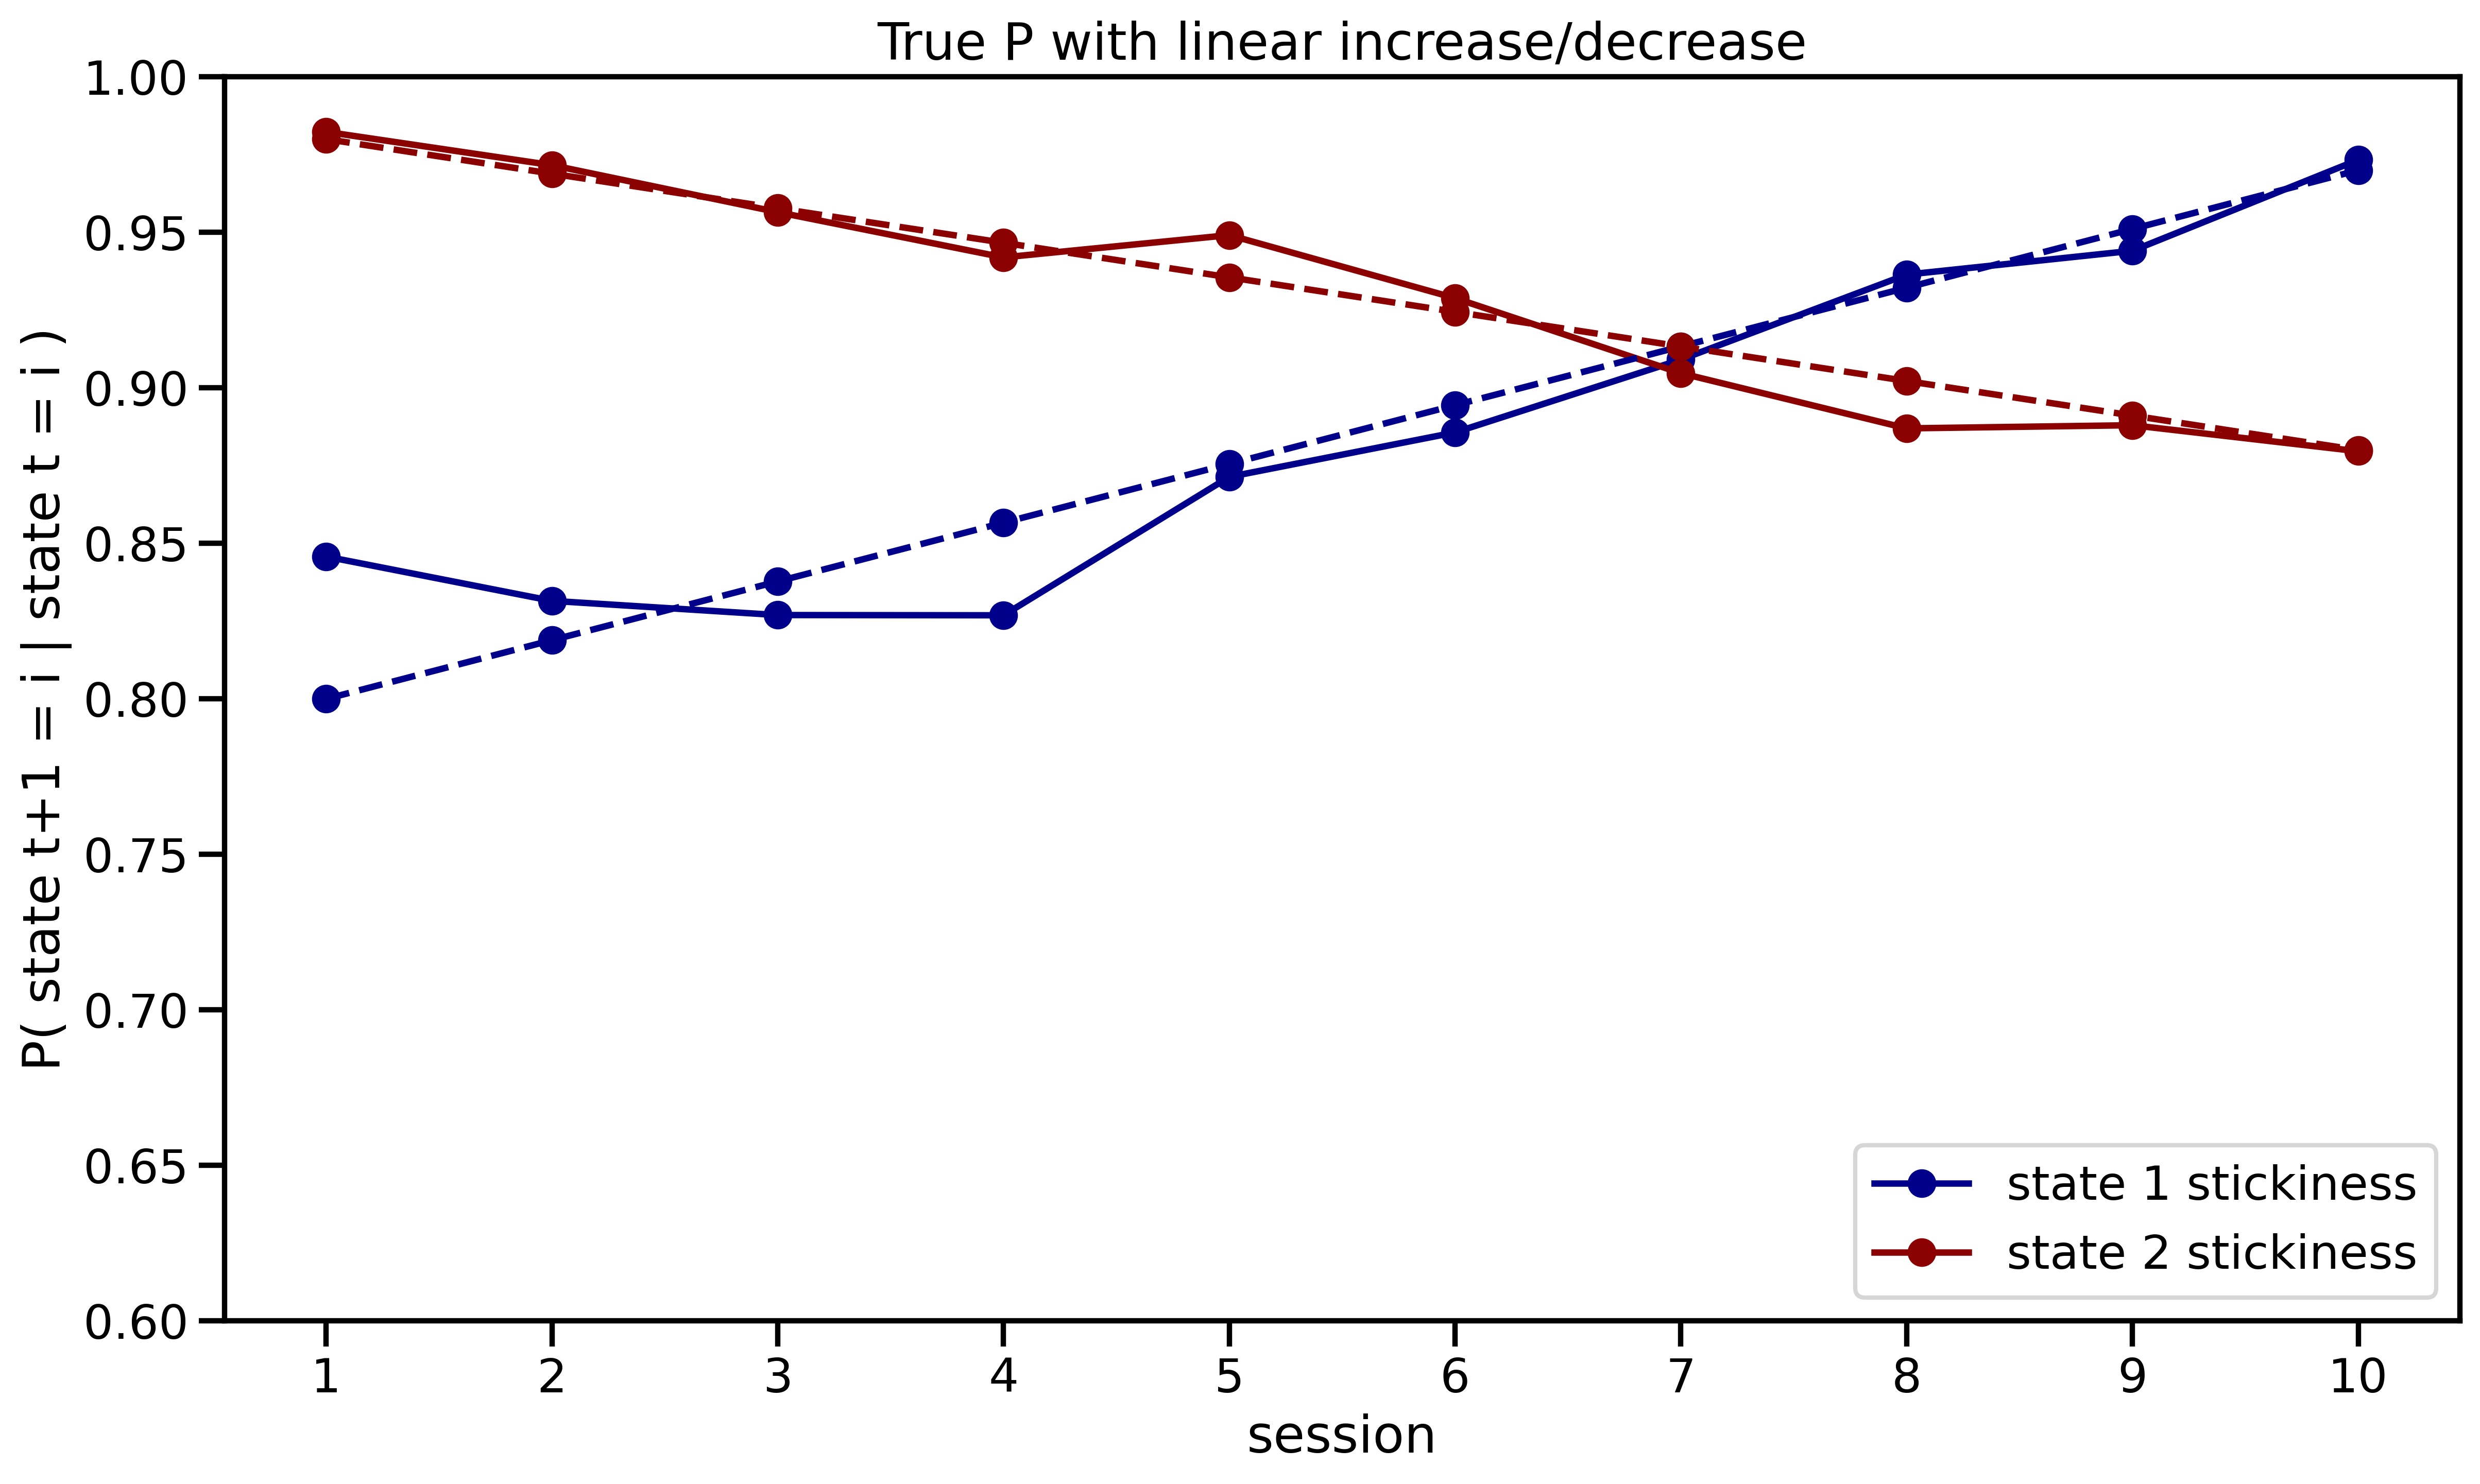

In [19]:
fig, axes = plt.subplots(1, figsize = (14,8), dpi=400)
plotting_transition_matrix_stickiness(checkP, sessInd, axes, trueP=trueP, title=f'True P with linear increase/decrease', save_fig=False)

In [25]:
# Fitting for different values of alpha
alphaList = [4**x for x in list(np.arange(-1,2, dtype=float))] + [4**x for x in list(np.arange(2,5,0.5, dtype=float))] + [4**x for x in list(np.arange(5,10,1, dtype=float))]
maxiter=400
allLl = np.zeros((len(alphaList),maxiter))
allP = np.zeros((len(alphaList),N,K,K))
allW = np.zeros((len(alphaList),N,K,D,C))
testLl = np.zeros((len(alphaList)))

for indAlpha in range(0,len(alphaList)): 
   print(f'indAlpha {indAlpha}')

   # fit
   allP[indAlpha], allW[indAlpha], allLl[indAlpha] = dGLMHMM.fit(trainX, trainY,  initP=checkP, initW=checkW, sigma=reshapeSigma(0.2, K, D), alpha=alphaList[indAlpha], globalP=checkP0, sessInd=sessInd, pi0=None, maxIter=maxiter, tol=1e-3) # fit the model
   
   # evaluate
   testPhi = dGLMHMM.observation_probability(testX, reshapeWeights(allW[indAlpha], sessInd, testSessInd))
   for s in range(0, S):
      _, _, temp = dGLMHMM.forward_pass(testY[testSessInd[s]:testSessInd[s+1]],allP[indAlpha],testPhi[testSessInd[s]:testSessInd[s+1]])
      testLl[indAlpha] += temp
   
testLl = testLl / testSessInd[-1] # normalizing to the total number of trials in test
    
np.save(f'../data/Ll_N={N}_{K}_state_linearP', allLl)
np.save(f'../data/P_N={N}_{K}_state_linearP', allP)
np.save(f'../data/W_N={N}_{K}_state_linearP', allW)
np.save(f'../data/testLl_N={N}_{K}_state_linearP', testLl)

indAlpha 0
0
10
indAlpha 1
0
10
indAlpha 2
0
10
indAlpha 3
0
10
indAlpha 4
0
10
indAlpha 5
0
10
indAlpha 6
0
10
indAlpha 7
0
10
indAlpha 8
0
10
indAlpha 9
0
10
indAlpha 10
0
10
indAlpha 11
0
10
indAlpha 12
0
10
20
indAlpha 13
0
10
20


Text(0.5, 1.0, 'Model performance as a function of hyperparameter alpha')

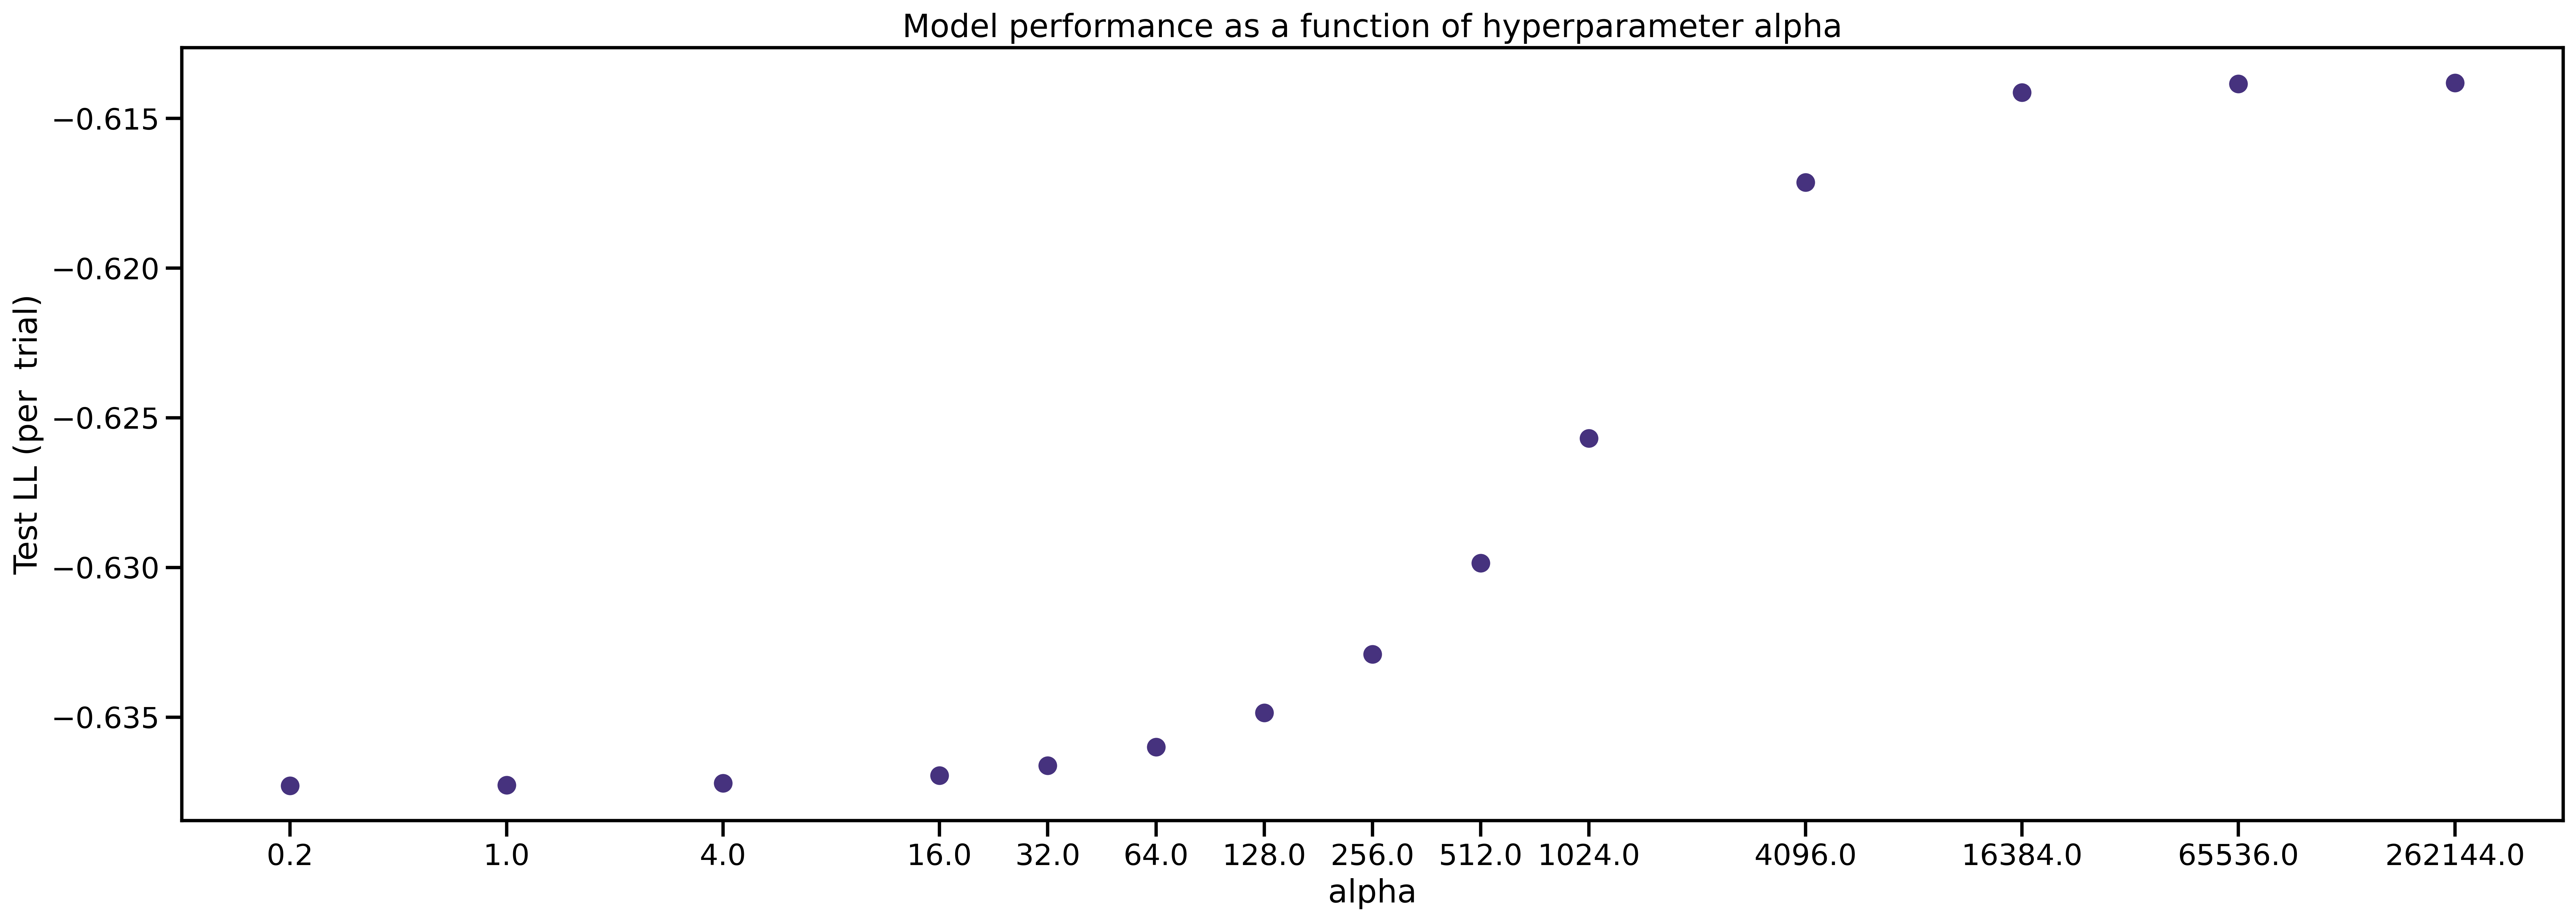

In [26]:
fig, axes = plt.subplots(1, figsize = (24,8), dpi=400)
colormap = sns.color_palette("viridis")
axes.scatter(np.log2(alphaList), testLl[:], color = colormap[0])
axes.set_xlabel('alpha')
axes.set_ylabel('Test LL (per  trial)')
# alphaListEven = [alphaList[ind] for ind in range(0,len(alphaList),2)]
# axes.set_xticks(np.log2(alphaListEven),[f'{np.round(alpha,1)}' for alpha in alphaListEven])
axes.set_xticks(np.log2(alphaList),[f'{np.round(alpha,1)}' for alpha in alphaList])
axes.set_title('Model performance as a function of hyperparameter alpha')
#fig.savefig(f'../figures/Alpha_vs_TestLl-version1.png', bbox_inches='tight', dpi=400)

[-0.63728665 -0.63727371 -0.63721757 -0.63699264 -0.63668937 -0.63610833
 -0.63501482 -0.63305773 -0.62984595 -0.6252473  -0.6163979  -0.61403037
 -0.61383073 -0.61380305]


In [27]:
# Fitting for different values of alpha
alphaList = [4**x for x in list(np.arange(-1,2, dtype=float))] + [4**x for x in list(np.arange(2,5,0.5, dtype=float))] + [4**x for x in list(np.arange(5,10,1, dtype=float))]
maxiter=400
allLl = np.zeros((len(alphaList),maxiter))
allP = np.zeros((len(alphaList),N,K,K))
allW = np.zeros((len(alphaList),N,K,D,C))
testLl = np.zeros((len(alphaList)))

for indAlpha in range(0,len(alphaList)): 
   print(f'indAlpha {indAlpha}')

   if (indAlpha == 0):
        # fit
        allP[indAlpha], allW[indAlpha], allLl[indAlpha] = dGLMHMM.fit(trainX, trainY,  initP=checkP, initW=checkW, sigma=reshapeSigma(0.2, K, D), alpha=alphaList[indAlpha], globalP=checkP0, sessInd=sessInd, pi0=None, maxIter=maxiter, tol=1e-3) # fit the model
   else:
       allP[indAlpha], allW[indAlpha], allLl[indAlpha] = dGLMHMM.fit(trainX, trainY,  initP=allP[indAlpha-1], initW=allW[indAlpha-1], sigma=reshapeSigma(0.2, K, D), alpha=alphaList[indAlpha], globalP=checkP0, sessInd=sessInd, pi0=None, maxIter=maxiter, tol=1e-3) # fit the model
   
   # evaluate
   testPhi = dGLMHMM.observation_probability(testX, reshapeWeights(allW[indAlpha], sessInd, testSessInd))
   for s in range(0, S):
      _, _, temp = dGLMHMM.forward_pass(testY[testSessInd[s]:testSessInd[s+1]],allP[indAlpha],testPhi[testSessInd[s]:testSessInd[s+1]])
      testLl[indAlpha] += temp
   
testLl = testLl / testSessInd[-1] # normalizing to the total number of trials in test
    
np.save(f'../data/Ll_N={N}_{K}_state_linearP_consec', allLl)
np.save(f'../data/P_N={N}_{K}_state_linearP_consec', allP)
np.save(f'../data/W_N={N}_{K}_state_linearP_consec', allW)
np.save(f'../data/testLl_N={N}_{K}_state_linearP_consec', testLl)

indAlpha 0
0
10
indAlpha 1
0
10
indAlpha 2
0
10
indAlpha 3
0
10
indAlpha 4
0
10
indAlpha 5
0
10
indAlpha 6
0
10
indAlpha 7
0
10
indAlpha 8
0
10
indAlpha 9
0
10
indAlpha 10
0
10
indAlpha 11
0
10
indAlpha 12
0
10
indAlpha 13
0
10


Text(0.5, 1.0, 'Model performance as a function of hyperparameter alpha')

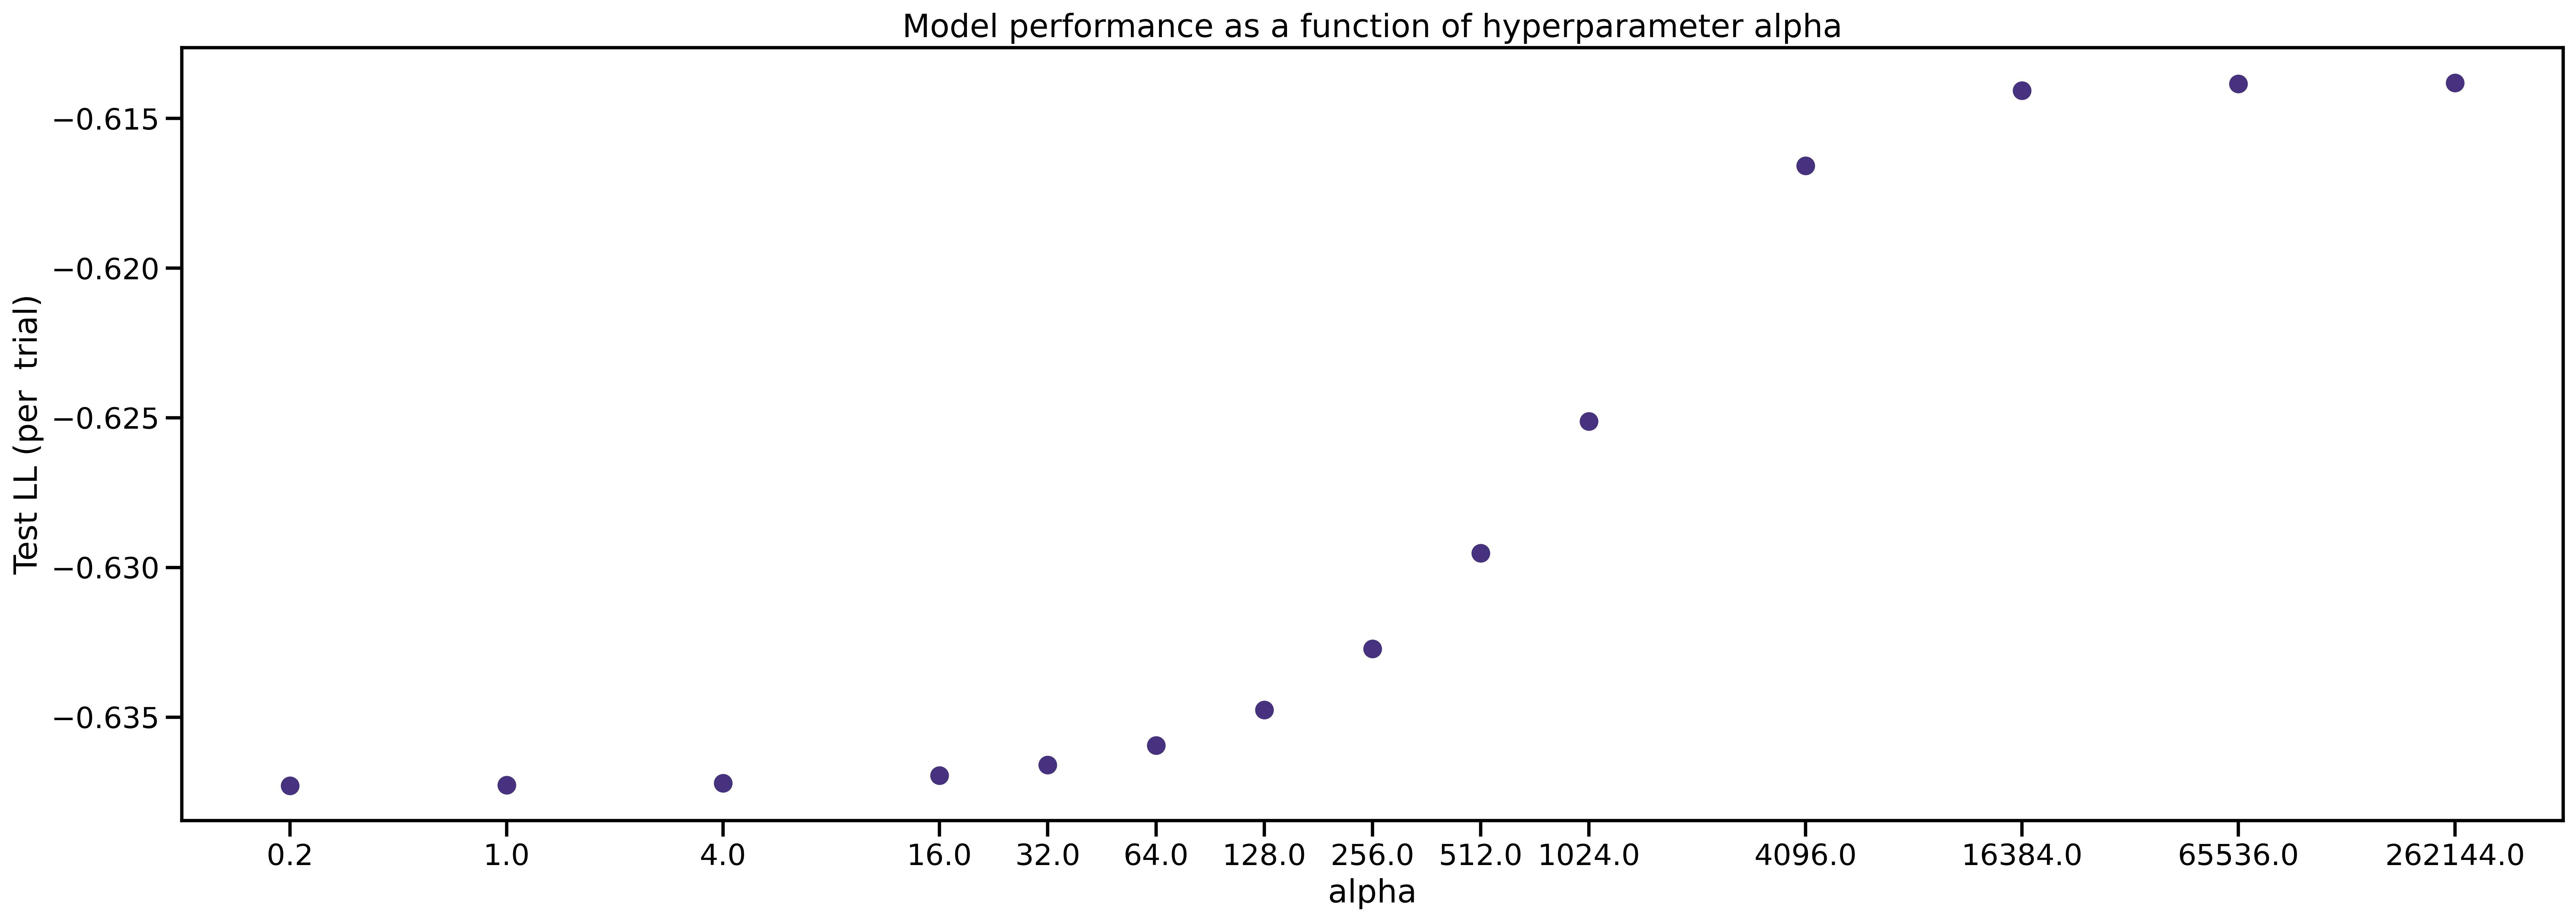

In [28]:
fig, axes = plt.subplots(1, figsize = (24,8), dpi=400)
colormap = sns.color_palette("viridis")
axes.scatter(np.log2(alphaList), testLl[:], color = colormap[0])
axes.set_xlabel('alpha')
axes.set_ylabel('Test LL (per  trial)')
# alphaListEven = [alphaList[ind] for ind in range(0,len(alphaList),2)]
# axes.set_xticks(np.log2(alphaListEven),[f'{np.round(alpha,1)}' for alpha in alphaListEven])
axes.set_xticks(np.log2(alphaList),[f'{np.round(alpha,1)}' for alpha in alphaList])
axes.set_title('Model performance as a function of hyperparameter alpha')
#fig.savefig(f'../figures/Alpha_vs_TestLl-version1.png', bbox_inches='tight', dpi=400)

In [37]:
print(checkLl/testSessInd[-1])

[-0.6132829  -0.61222754 -0.61182137 -0.61147151 -0.61116506 -0.61089605
 -0.61066038 -0.61045481 -0.61027667 -0.61012365 -0.60999356 -0.60988426
 -0.60979353 -0.6097191  -0.60965872 -0.60961023 -0.60957164 -0.60954116
 -0.60951723 -0.60949854 -0.609484   -0.6094727  -0.60946395 -0.60945718
 -0.60945193 -0.60944787 -0.60944471 -0.60944225 -0.60944034 -0.60943885
 -0.60943767 -0.60943675 -0.60943602 -0.60943543 -0.60943497 -0.6094346
 -0.6094343  -0.60943406 -0.60943386 -0.60943369 -0.60943356 -0.60943345
 -0.60943335 -0.60943327 -0.60943321 -0.60943315 -0.6094331  -0.60943306
 -0.60943302 -0.60943299 -0.60943297 -0.60943294 -0.60943292 -0.60943291
 -0.60943289 -0.60943288 -0.60943287 -0.60943286  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.   

In [29]:
globalP = trueP.mean(axis=0)
print(globalP.shape)

# Fitting for different values of alpha
alphaList = [4**x for x in list(np.arange(-1,2, dtype=float))] + [4**x for x in list(np.arange(2,5,0.5, dtype=float))] + [4**x for x in list(np.arange(5,10,1, dtype=float))]
maxiter=400
allLl = np.zeros((len(alphaList),maxiter))
allP = np.zeros((len(alphaList),N,K,K))
allW = np.zeros((len(alphaList),N,K,D,C))
testLl = np.zeros((len(alphaList)))

for indAlpha in range(0,len(alphaList)): 
   print(f'indAlpha {indAlpha}')

   if (indAlpha == 0):
        # fit
        allP[indAlpha], allW[indAlpha], allLl[indAlpha] = dGLMHMM.fit(trainX, trainY,  initP=checkP, initW=checkW, sigma=reshapeSigma(0.2, K, D), alpha=alphaList[indAlpha], globalP=globalP, sessInd=sessInd, pi0=None, maxIter=maxiter, tol=1e-3) # fit the model
   else:
       allP[indAlpha], allW[indAlpha], allLl[indAlpha] = dGLMHMM.fit(trainX, trainY,  initP=allP[indAlpha-1], initW=allW[indAlpha-1], sigma=reshapeSigma(0.2, K, D), alpha=alphaList[indAlpha], globalP=globalP, sessInd=sessInd, pi0=None, maxIter=maxiter, tol=1e-3) # fit the model
   
   # evaluate
   testPhi = dGLMHMM.observation_probability(testX, reshapeWeights(allW[indAlpha], sessInd, testSessInd))
   for s in range(0, S):
      _, _, temp = dGLMHMM.forward_pass(testY[testSessInd[s]:testSessInd[s+1]],allP[indAlpha],testPhi[testSessInd[s]:testSessInd[s+1]])
      testLl[indAlpha] += temp
   
testLl = testLl / testSessInd[-1] # normalizing to the total number of trials in test
    
np.save(f'../data/Ll_N={N}_{K}_state_linearP_globalPmean', allLl)
np.save(f'../data/P_N={N}_{K}_state_linearP_globalPmean', allP)
np.save(f'../data/W_N={N}_{K}_state_linearP_globalPmean', allW)
np.save(f'../data/testLl_N={N}_{K}_state_linearP_globalPmean', testLl)



(2, 2)
indAlpha 0
0
10
indAlpha 1
0
10
indAlpha 2
0
10
indAlpha 3
0
10
indAlpha 4
0
10
indAlpha 5
0
10
indAlpha 6
0
10
indAlpha 7
0
10
indAlpha 8
0
10
indAlpha 9
0
10
indAlpha 10
0
10
indAlpha 11
0
10
indAlpha 12
0
10
indAlpha 13
0
10


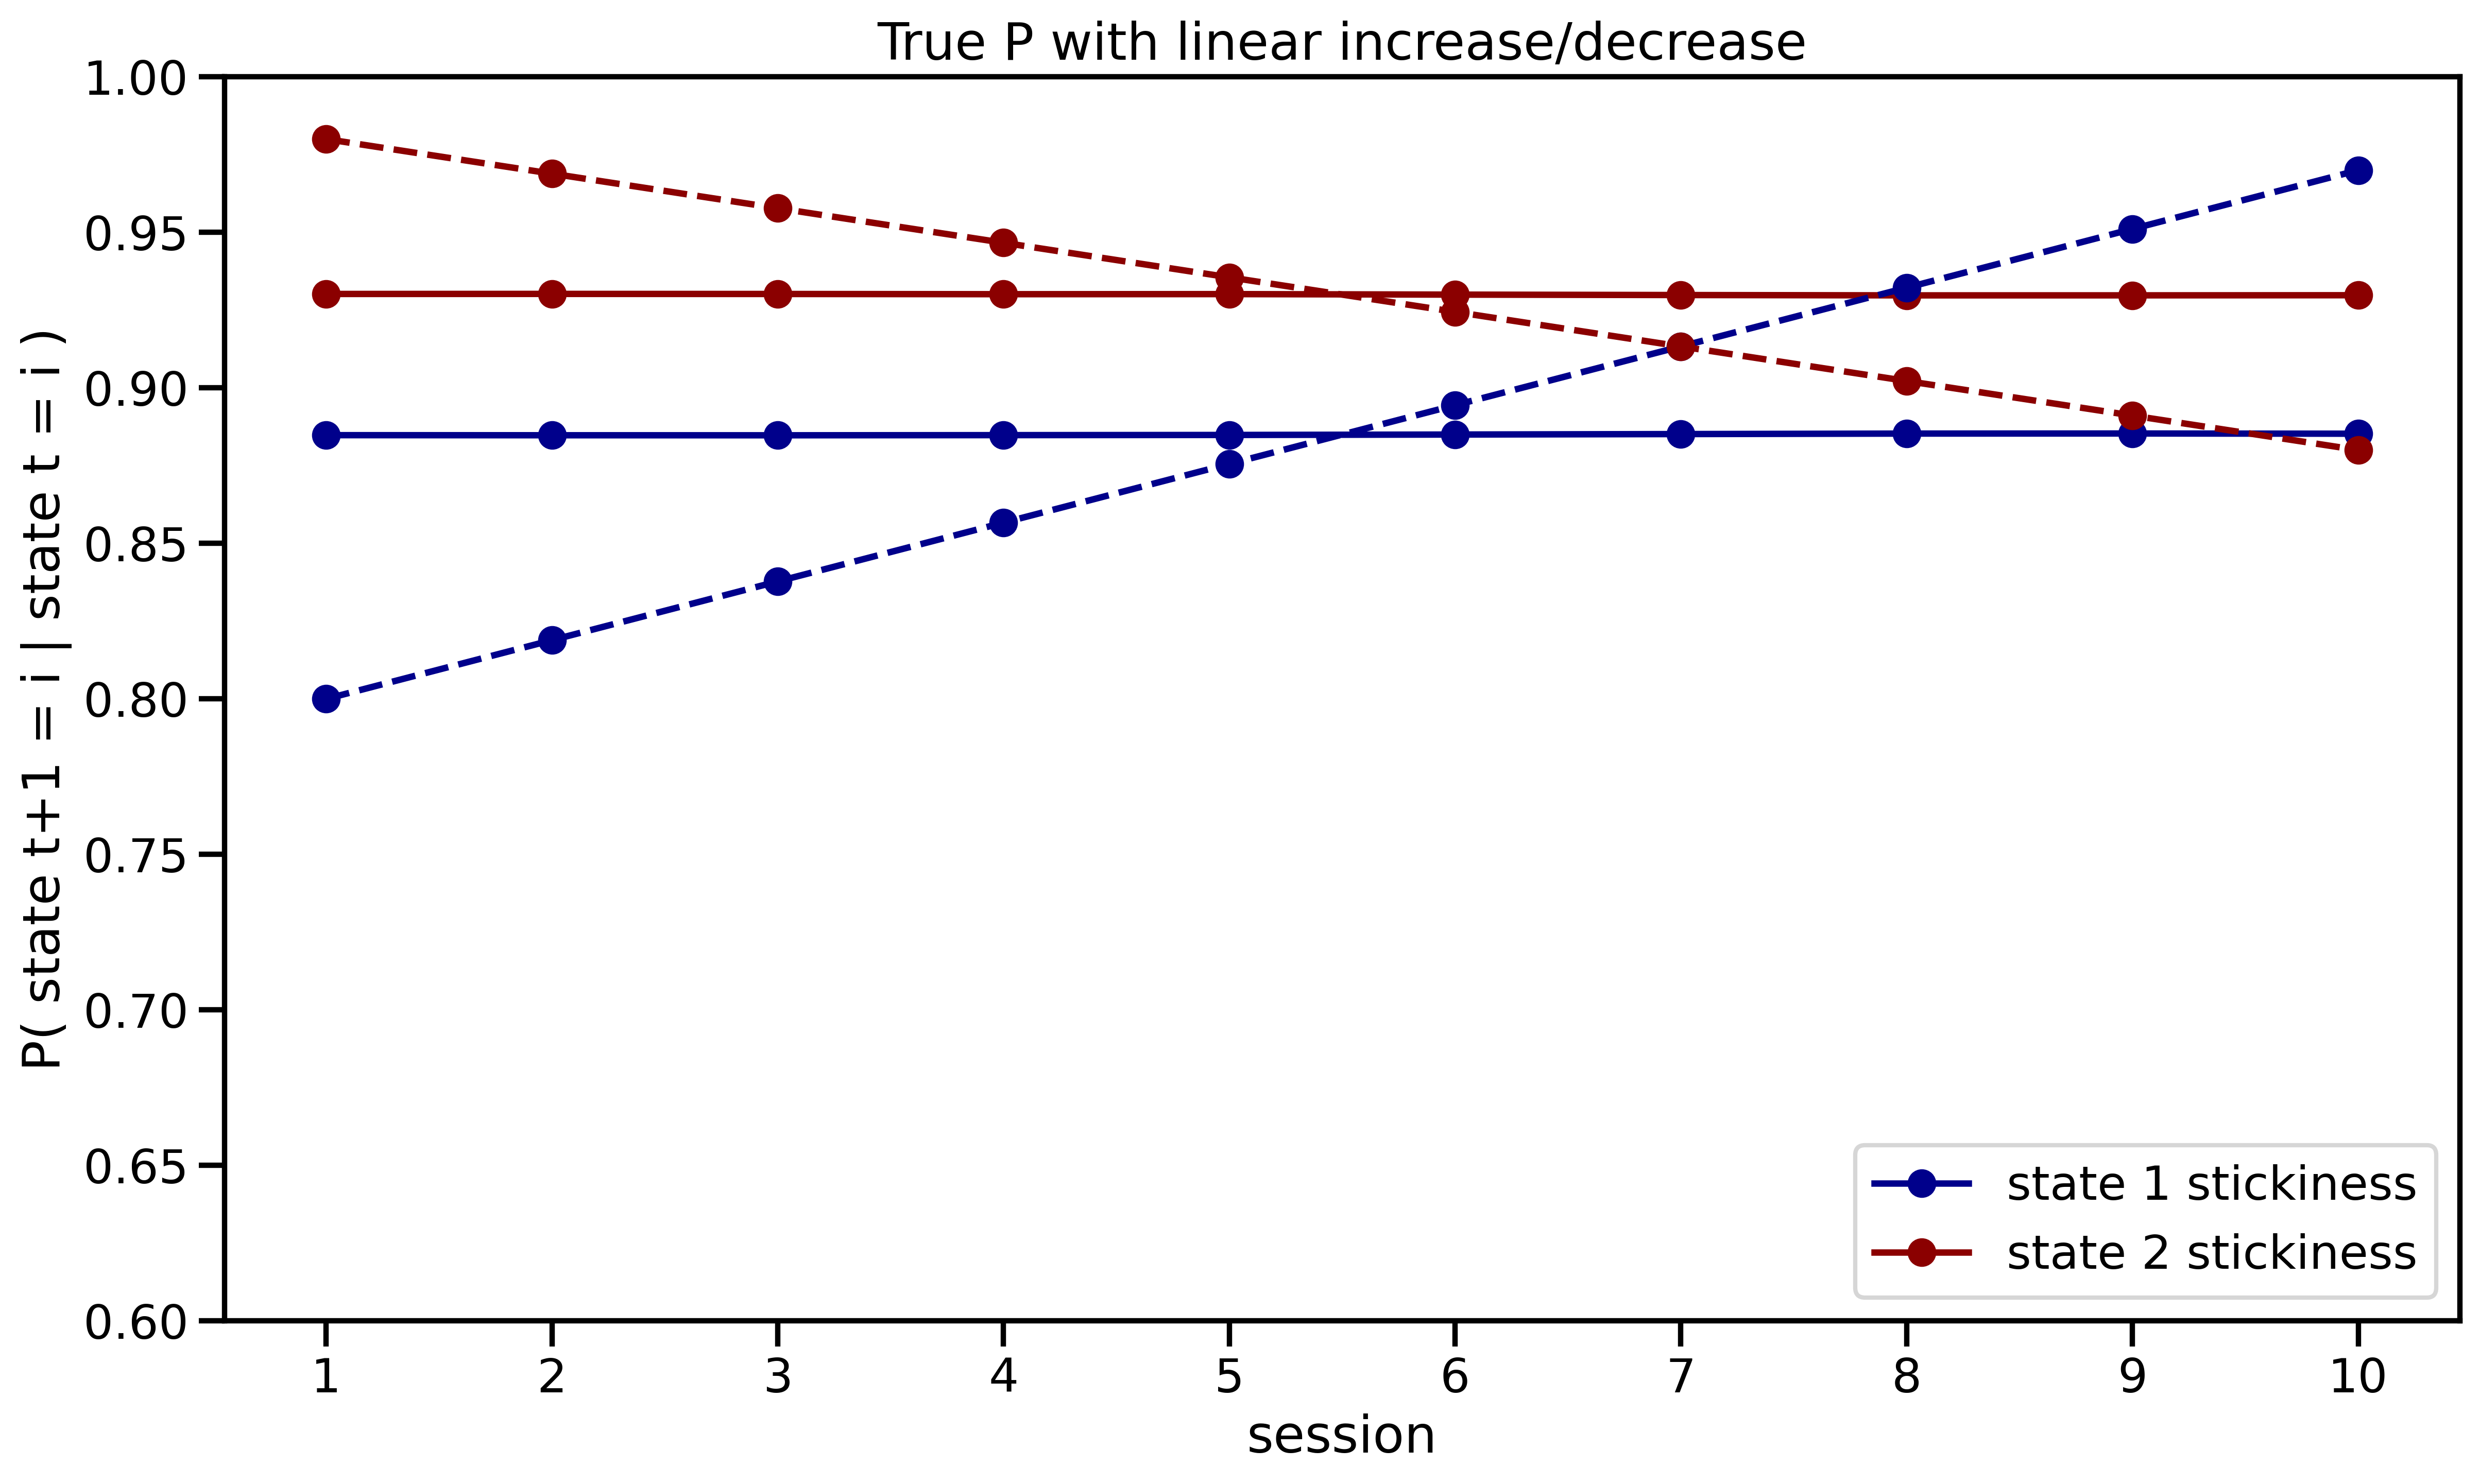

In [41]:
fig, axes = plt.subplots(1, figsize = (14,8), dpi=400)
plotting_transition_matrix_stickiness(allP[-1], sessInd, axes, trueP=trueP, title=f'True P with linear increase/decrease', save_fig=False)

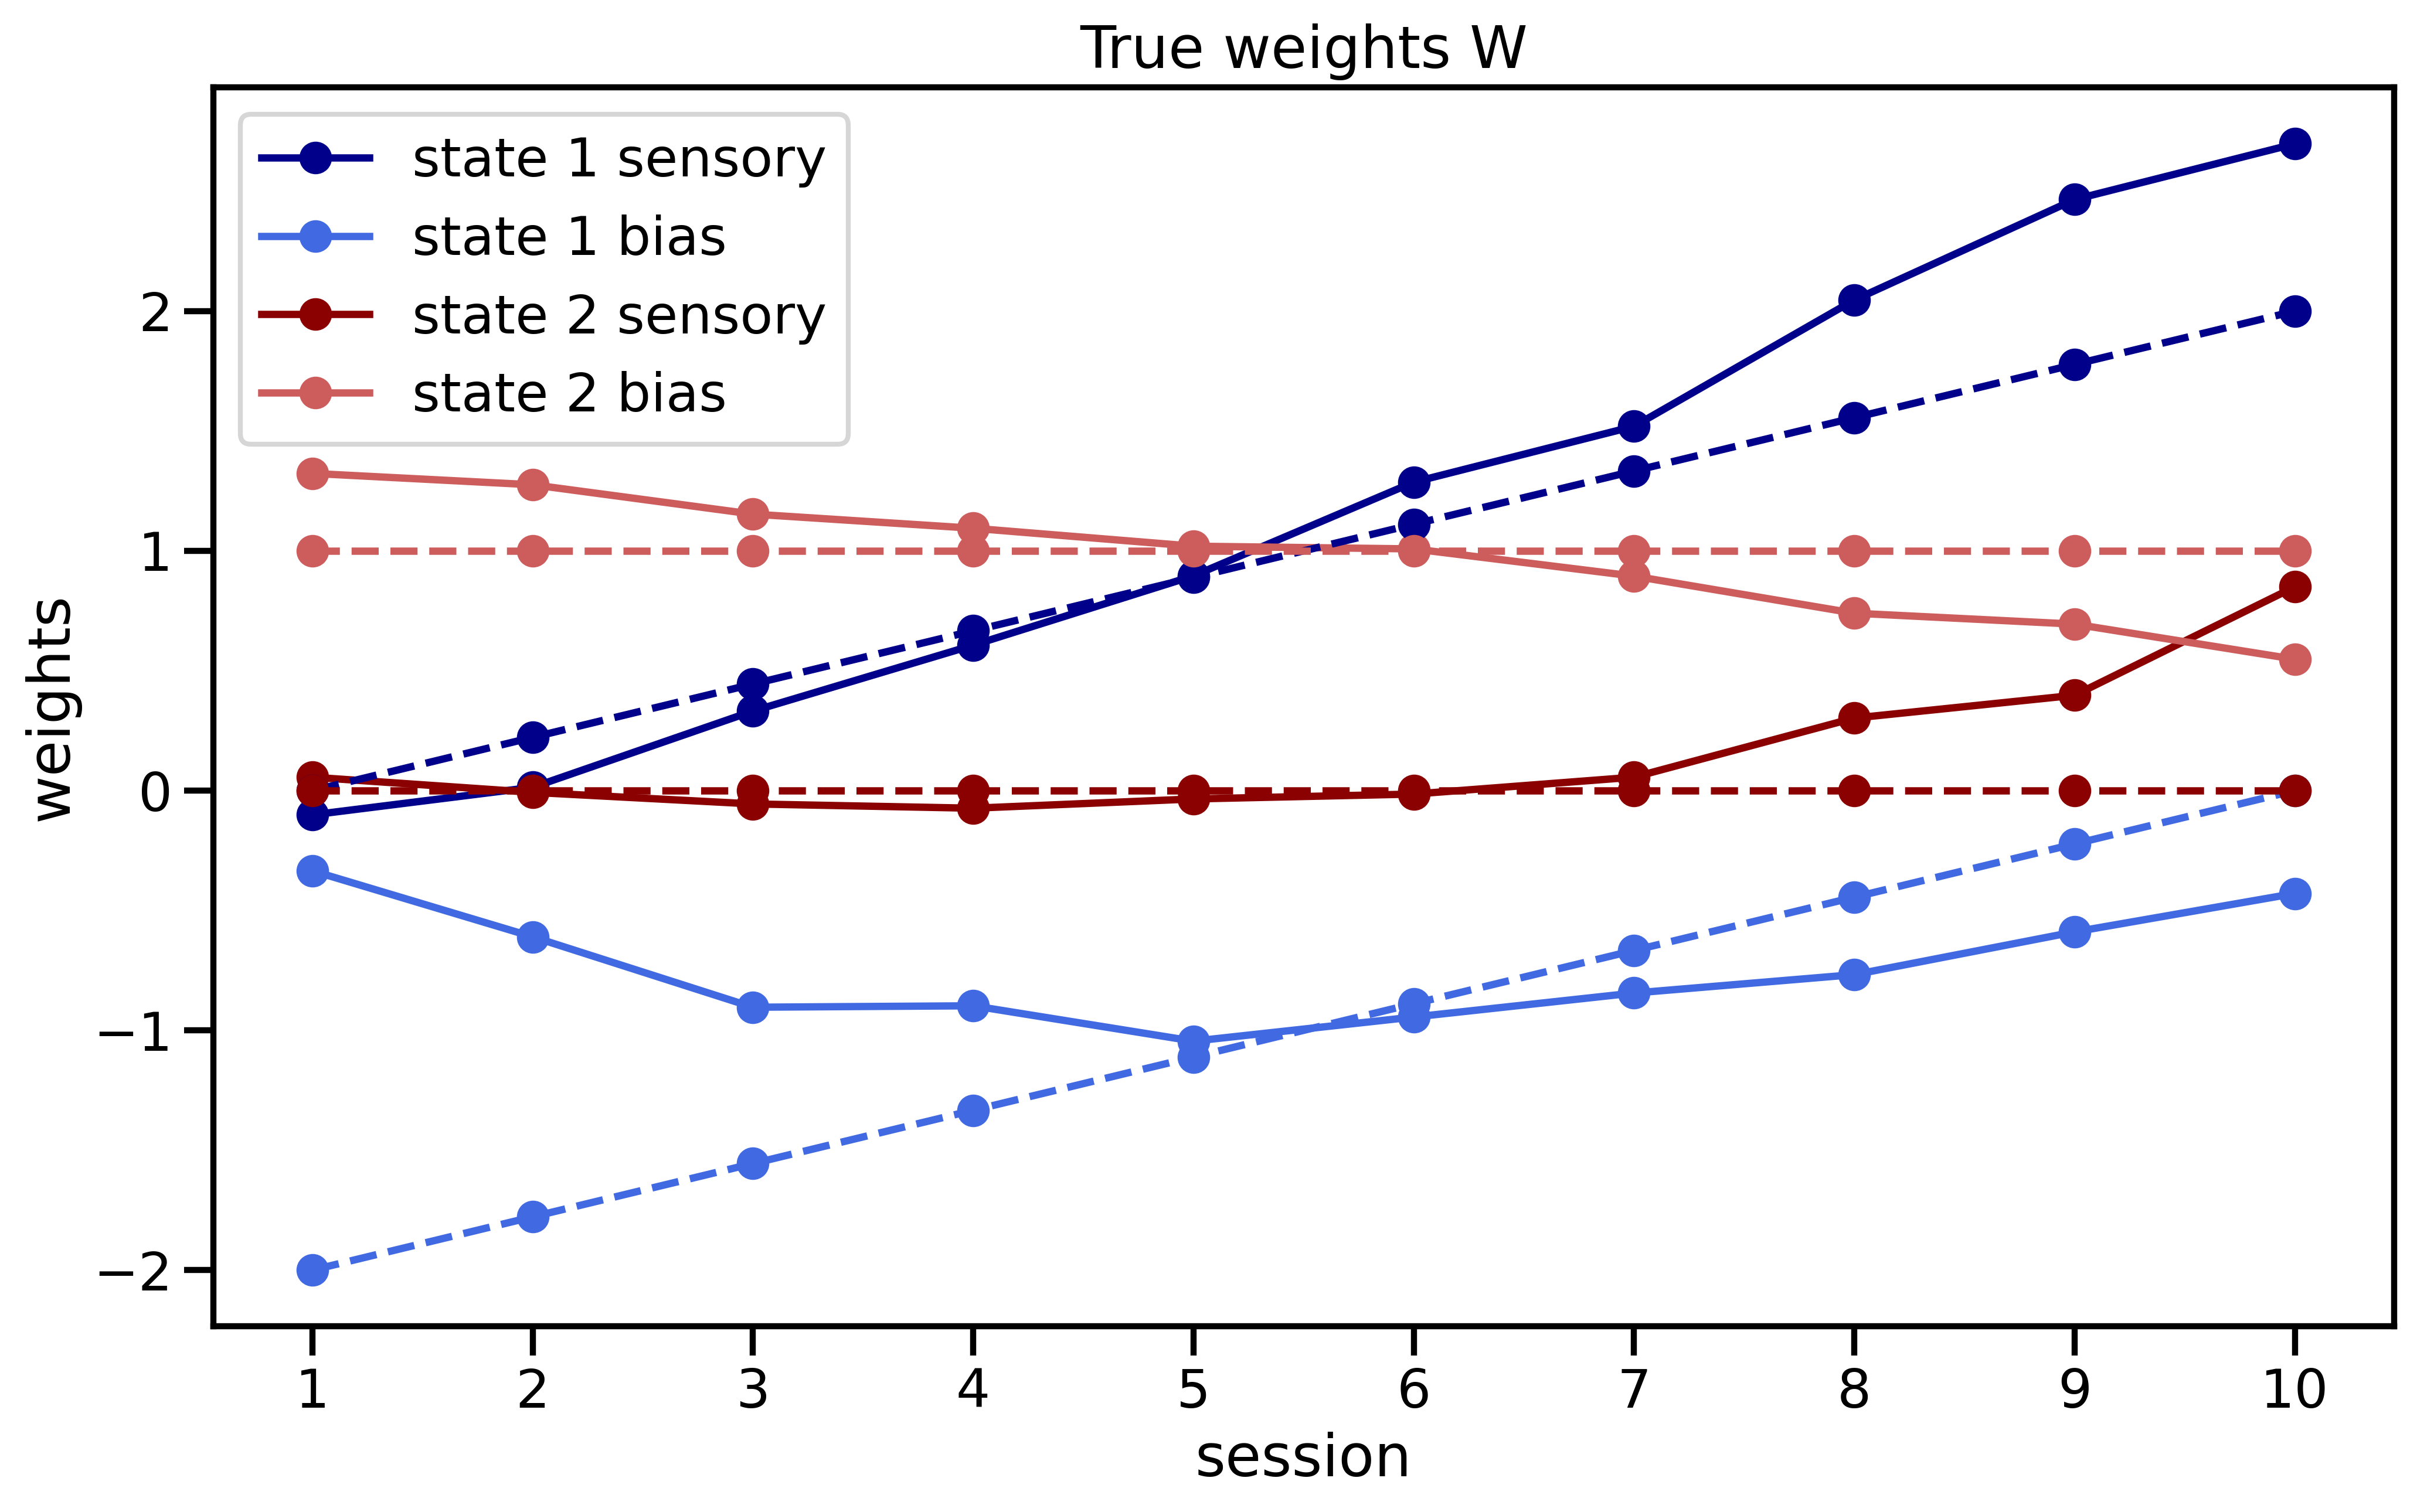

In [42]:
fig, axes = plt.subplots(1, figsize = (12,7), dpi=400)
plotting_weights(w=allW[-1], sessInd=sessInd, axes=axes, trueW=trueW, title='True weights W', save_fig=False)

Text(0.5, 1.0, 'Model performance as a function of hyperparameter alpha')

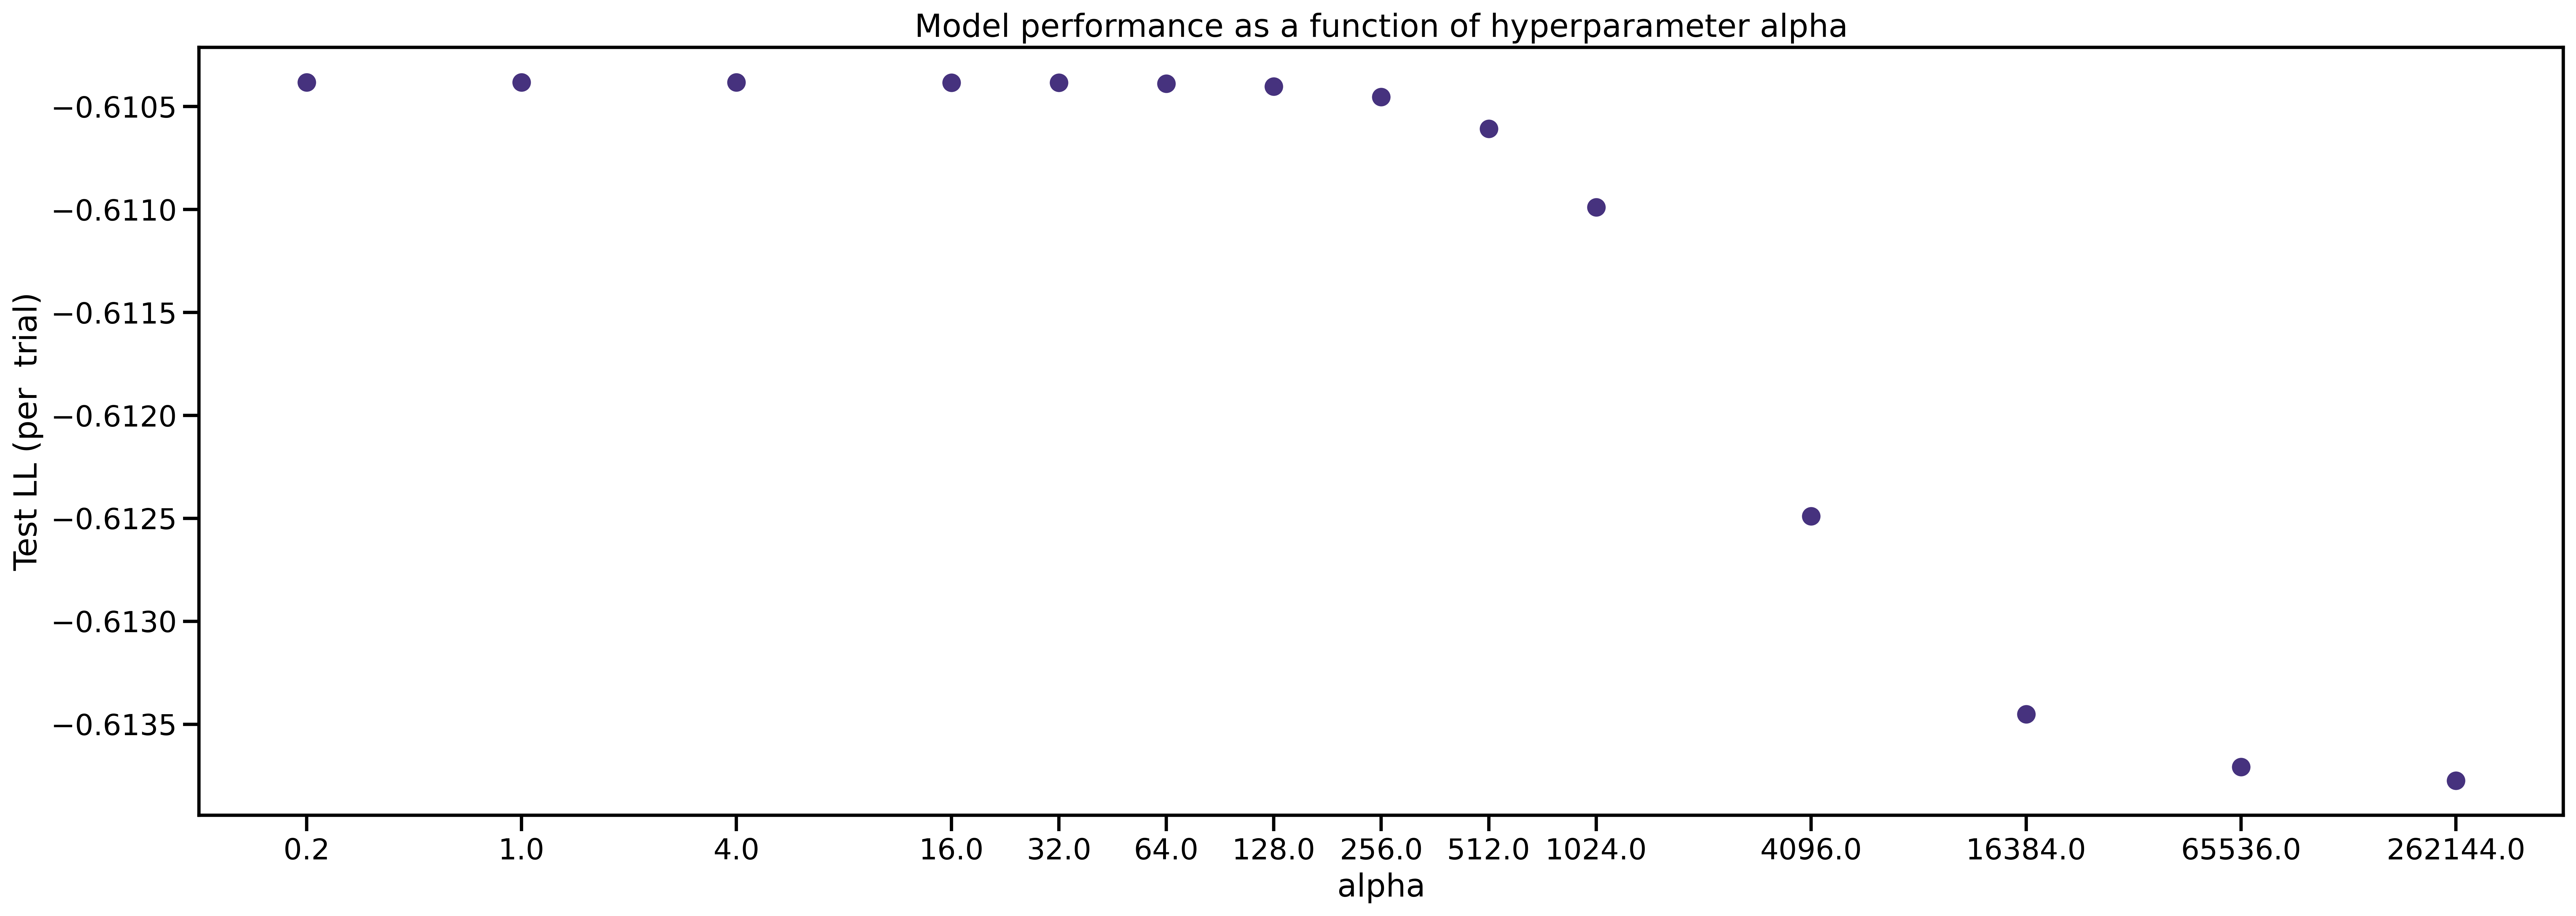

In [57]:
fig, axes = plt.subplots(1, figsize = (24,8), dpi=400)
colormap = sns.color_palette("viridis")
axes.scatter(np.log2(alphaList), testLl[:], color = colormap[0])
axes.set_xlabel('alpha')
axes.set_ylabel('Test LL (per  trial)')
# alphaListEven = [alphaList[ind] for ind in range(0,len(alphaList),2)]
# axes.set_xticks(np.log2(alphaListEven),[f'{np.round(alpha,1)}' for alpha in alphaListEven])
axes.set_xticks(np.log2(alphaList),[f'{np.round(alpha,1)}' for alpha in alphaList])
axes.set_title('Model performance as a function of hyperparameter alpha')
#fig.savefig(f'../figures/Alpha_vs_TestLl-version1.png', bbox_inches='tight', dpi=400)

In [56]:
testLl = np.zeros((len(alphaList)))

DiffSessLl = np.zeros((S))

for indAlpha in range(0,len(alphaList)): 
   
   # evaluate
   testPhi = dGLMHMM.observation_probability(testX, allW[indAlpha])
   for s in range(0, S):
      _, _, temp = dGLMHMM.forward_pass(testY[testSessInd[s]:testSessInd[s+1]],allP[indAlpha][testSessInd[s]:testSessInd[s+1]],testPhi[testSessInd[s]:testSessInd[s+1]])
      testLl[indAlpha] += temp
      if (indAlpha == 0 or indAlpha == len(alphaList)-1):
         print(temp)
      if (indAlpha == 0):
         DiffSessLl[s] = temp
      elif (indAlpha == len(alphaList)-1):
         DiffSessLl[s] = DiffSessLl[s] - temp

print(DiffSessLl)
print(testLl)

   
testLl = testLl / testSessInd[-1] # normalizing to the total number of trials in test

-6123.842415616373
-6251.127417289633
-6339.572839120849
-6466.646275528835
-6448.798746911416
-6424.580568597083
-6271.28923450479
-5980.460776512716
-5643.001104378523
-5088.902121269012
-6169.672401511446
-6301.297267757811
-6368.243446609963
-6481.304366031651
-6442.442072175636
-6424.807004230187
-6272.4688154432515
-6019.601679602543
-5710.502736536493
-5186.962392206501
[45.8299859  50.16985047 28.67060749 14.6580905  -6.35667474  0.22643563
  1.17958094 39.14090309 67.50163216 98.06027094]
[-61038.22149973 -61038.2328584  -61038.23932264 -61038.27735086
 -61038.3667708  -61038.76174165 -61040.24755248 -61045.33738151
 -61060.66086534 -61098.81128269 -61248.94553764 -61345.07387638
 -61370.69887815 -61377.30218211]


In [44]:
print(testX)

[[ 1.          1.37246648]
 [ 1.         -1.48886087]
 [ 1.          0.38200701]
 ...
 [ 1.         -0.0581972 ]
 [ 1.          1.26241543]
 [ 1.          1.26241543]]
